# 1/31/23 - Putting oriented interfaces back into S = 1 model

### Yesterday, worked on isotropic models. Today, going to put back into oriented model and see how it affects results.
Here, I need to generate morphologies with S=1 everywhere. First, imports:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import MolecularGlass_Nov as MG_Nov

/home/tbm/software/anaconda/lib/python3.8/site-packages/cupy/_environment.py:434: UserWarning: 
--------------------------------------------------------------------------------

  CuPy may not function correctly because multiple CuPy packages are installed
  in your environment:

    cupy, cupy-cuda113

  Follow these steps to resolve this issue:

    1. For all packages listed above, run the following command to remove all
       existing CuPy installations:

         $ pip uninstall <package_name>

      If you previously installed CuPy via conda, also run the following:

         $ conda uninstall cupy

    2. Install the appropriate CuPy package.
       Refer to the Installation Guide for detailed instructions.

         https://docs.cupy.dev/en/stable/install.html

--------------------------------------------------------------------------------

  warnings.warn(f'''


Grab an AFM:

In [2]:
img_folder = '/home/ceb10/OldRuns/AFM_Images/'
AFM280 = f'{img_folder}/B280_Output3_n20to15.png'
AFM310  = f'{img_folder}/B310_Output1_n5to5.png'
AFM325 = f'{img_folder}/B325_Output3_n5to5.png'

# these make it easy to use "AFM choice" (0, 1, or 2) as a parameter
AFM_files=[AFM280,AFM310,AFM325]; Tsubs = [280,310,325]
hmins = [17,6.9,5.5]; hpluses = [17,5.8,5.0]
blocks = [51,51,81]; filters = [5,5,7]
offsets=[0.001,0.001,0.003]


#AFM tuple format: (AFM_file, Tsub, h_film, hminus, hplus, block_size, filter_size, offset, voxel_size, res)
AFM_info_280 = (AFM_files[0], Tsubs[0], 70., hmins[0], hpluses[0], blocks[0], filters[0],offsets[0], 1.95, 2048)
AFM_info_310 = (AFM_files[1], Tsubs[1], 70., hmins[1], hpluses[1], blocks[1], filters[1],offsets[1], 1.95, 2048)
AFM_info_325 = (AFM_files[2], Tsubs[2], 70., hmins[2], hpluses[2], blocks[2], filters[2],offsets[2], 1.95, 2048)

running_folder = '/home/ceb10/Jan2023/'

### Isotropic morphology function MODIFIED to make all the S matrices full of ones

In [3]:
from skimage import io
from skimage.color import rgb2gray
from skimage.filters import threshold_local, gaussian
import skimage

def base_morph_2D_purityblur(AFM_info, sigma_nm=0., purity=100.,default_S=1.0,scramble_Eulers=True):
    '''
    Calculates a morphology with binary phases (no interfacial orientation). Has an option to make S = 1 everywhere, with or without the Euler angles scrambled. 
    
    Parameters:
    
    AFM_info: tuple consisting of (AFM_file, Tsub, h_film, hminus, hplus, block_size, filter_size, offset, voxel_size, res)
    
    sigma_nm: takes a sigma blur in nm
    
    purity: self-explanatory
    
    default_S: make all material have S. Default here is S = 1; I have added a print statement to make sure I remember this, since it's new.
    
    scramble_Eulers: Makes psi and theta for every material random.
    
    
    Returns: morph_to_save, hole_binary, matrix_binary
    
    
    '''
    AFM_file = AFM_info[0]; Tsub = AFM_info[1]; h_film = AFM_info[2]; hminus = AFM_info[3]; hplus = AFM_info[4];
    block_size = AFM_info[5]; filter_size = AFM_info[6]; offset = AFM_info[7]; voxel_size = AFM_info[8]; res = AFM_info[9]
    
    holes,matrix,gray_image = process_image(AFM_file,block_size,filter_size,offset) # made filters for what is material a and what is mat b
    
    sigma_vox = sigma_nm / 1.95
    # blur holes first
    holes_blur = skimage.filters.gaussian(holes*1., sigma=(sigma_vox, sigma_vox), truncate=3., multichannel=False) # turns a boolean into a np, by the way
    matrix_blur = np.subtract(np.ones(np.shape(holes_blur),dtype=float),holes_blur)

    TPD_hole_pct = (50. + 0.5*purity)/100.; TPD_matrix_pct = (50 - 0.5*purity)/100. # turns the purity parameter into percents in hole, matrix
    DO_hole_pct = (50 - 0.5*purity)/100.; DO_matrix_pct = (50 + 0.5*purity)/100.
    
    # remember I may need to re-think purity parameter; mass balance with heights as well as the 2D surface area
    holes_TPD = holes_blur*TPD_hole_pct; holes_DO = holes_blur*DO_hole_pct
    matrix_TPD = matrix_blur*TPD_matrix_pct; matrix_DO = matrix_blur*DO_matrix_pct

    h_max = h_film+np.abs(hplus); h_min = h_film-np.abs(hminus) # accounting for vacuum fractions
    heights = (gray_image*(np.abs(hplus)+np.abs(hminus))+(h_min))       
    Vfrac_V = (h_max - heights)/h_max #volume fraction of each voxel that is vacuum
    Vfrac_M = 1. - Vfrac_V # this will turn into numbers like 0.9 - so that is the pctg of material in it. Can use that as a scale factor for the 

    all_TPD = np.add(holes_TPD,matrix_TPD); all_DO = np.add(holes_DO,matrix_DO)

    TPD_adjusted = np.multiply(Vfrac_M,all_TPD); DO_adjusted = np.multiply(Vfrac_M,all_DO)

    Vfrac_TPD = np.expand_dims(TPD_adjusted,axis=0); Vfrac_DO = np.expand_dims(DO_adjusted, axis=0) # expanding dims for compatibility with CyRSOXS (2048x2048 to 1x2048x2048)
    Vfrac_V = np.expand_dims(Vfrac_V,axis=0)

    zeros_mat = np.zeros(np.shape(Vfrac_V),dtype=float)
    ones_mat = np.ones(np.shape(Vfrac_V),dtype=float)
    
    hole_binary = holes; matrix_binary = matrix # these outputs are necessary for adding orientation later; however, this way, we only have to generate the isotropic morphology once
    # this has changed - we automatically set S to 1 everywhere. Theta and psi are automatically 0 because we haven't added orientation yet
    # HOWEVER, note that this would not actually create an "isotropic" morphology - it's completely aligned, so this is meaningless, really
    bulk_theta_dist = np.random.uniform(0.,np.pi,np.shape(Vfrac_TPD))
    bulk_psi_dist = np.random.uniform(0.,np.pi,np.shape(Vfrac_TPD))
    
    if scramble_Eulers == True:
        morph_to_save = [Vfrac_TPD, ones_mat*default_S, bulk_theta_dist, bulk_psi_dist, Vfrac_DO, ones_mat*default_S, bulk_theta_dist, bulk_psi_dist, Vfrac_V, zeros_mat, zeros_mat, zeros_mat]
    elif scramble_Eulers == False:
        morph_to_save = [Vfrac_TPD, ones_mat*default_S, zeros_mat, zeros_mat, Vfrac_DO, ones_mat*default_S, zeros_mat, zeros_mat, Vfrac_V, zeros_mat, zeros_mat, zeros_mat]
    else:
        print('Do you know how to use Booleans')
    

    print(f'Assigned S = {default_S} to all voxels')
    return morph_to_save, hole_binary, matrix_binary

def process_image(AFM_filename,block_size=91,filter_size=7, offset=0.007):
    moon = io.imread(AFM_filename); image = rgb2gray(moon)
    dim = image.shape[0]
    a_local_thresh = threshold_local(image,block_size=block_size, offset=offset)
    a_image_blur = gaussian(image, filter_size, output=None, mode='nearest')
    a  = a_image_blur < (a_local_thresh - offset)
    b = np.invert(a)
    gray_image = image
    return a,b,gray_image 

In [4]:
def base_morph_tricks(AFM_info, sigma_nm=0., purity=100.,default_S=1.0,scramble_theta=True, scramble_psi=True, theta_set=0.,psi_set=0.):
    '''
    Calculates a morphology with binary phases (no interfacial orientation). Has an option to make S = 1 everywhere, with or without the Euler angles scrambled. 
    
    Parameters:
    
    AFM_info: tuple consisting of (AFM_file, Tsub, h_film, hminus, hplus, block_size, filter_size, offset, voxel_size, res)
    
    sigma_nm: takes a sigma blur in nm
    
    purity: self-explanatory
    
    default_S: make all material have S. Default here is S = 1; I have added a print statement to make sure I remember this, since it's new.
    
    scramble_Eulers: Makes psi and theta for every material random.
    
    
    Returns: morph_to_save, hole_binary, matrix_binary
    
    
    '''
    AFM_file = AFM_info[0]; Tsub = AFM_info[1]; h_film = AFM_info[2]; hminus = AFM_info[3]; hplus = AFM_info[4];
    block_size = AFM_info[5]; filter_size = AFM_info[6]; offset = AFM_info[7]; voxel_size = AFM_info[8]; res = AFM_info[9]
    
    holes,matrix,gray_image = process_image(AFM_file,block_size,filter_size,offset) # made filters for what is material a and what is mat b
    
    sigma_vox = sigma_nm / 1.95
    # blur holes first
    holes_blur = skimage.filters.gaussian(holes*1., sigma=(sigma_vox, sigma_vox), truncate=3., multichannel=False) # turns a boolean into a np, by the way
    matrix_blur = np.subtract(np.ones(np.shape(holes_blur),dtype=float),holes_blur)

    TPD_hole_pct = (50. + 0.5*purity)/100.; TPD_matrix_pct = (50 - 0.5*purity)/100. # turns the purity parameter into percents in hole, matrix
    DO_hole_pct = (50 - 0.5*purity)/100.; DO_matrix_pct = (50 + 0.5*purity)/100.
    
    # remember I may need to re-think purity parameter; mass balance with heights as well as the 2D surface area
    holes_TPD = holes_blur*TPD_hole_pct; holes_DO = holes_blur*DO_hole_pct
    matrix_TPD = matrix_blur*TPD_matrix_pct; matrix_DO = matrix_blur*DO_matrix_pct

    h_max = h_film+np.abs(hplus); h_min = h_film-np.abs(hminus) # accounting for vacuum fractions
    heights = (gray_image*(np.abs(hplus)+np.abs(hminus))+(h_min))       
    Vfrac_V = (h_max - heights)/h_max #volume fraction of each voxel that is vacuum
    Vfrac_M = 1. - Vfrac_V # this will turn into numbers like 0.9 - so that is the pctg of material in it. Can use that as a scale factor for the 

    all_TPD = np.add(holes_TPD,matrix_TPD); all_DO = np.add(holes_DO,matrix_DO)

    TPD_adjusted = np.multiply(Vfrac_M,all_TPD); DO_adjusted = np.multiply(Vfrac_M,all_DO)

    Vfrac_TPD = np.expand_dims(TPD_adjusted,axis=0); Vfrac_DO = np.expand_dims(DO_adjusted, axis=0) # expanding dims for compatibility with CyRSOXS (2048x2048 to 1x2048x2048)
    Vfrac_V = np.expand_dims(Vfrac_V,axis=0)

    zeros_mat = np.zeros(np.shape(Vfrac_V),dtype=float)
    ones_mat = np.ones(np.shape(Vfrac_V),dtype=float)
    
    thetas_mat = np.copy(ones_mat); psis_mat = np.copy(ones_mat)
    
    hole_binary = holes; matrix_binary = matrix # these outputs are necessary for adding orientation later; however, this way, we only have to generate the isotropic morphology once
    # this has changed - we automatically set S to 1 everywhere. Theta and psi are automatically 0 because we haven't added orientation yet
    # HOWEVER, note that this would not actually create an "isotropic" morphology - it's completely aligned, so this is meaningless, really
#     bulk_theta_dist = np.random.uniform(0.,np.pi,np.shape(Vfrac_TPD))
#     bulk_psi_dist = np.random.uniform(0.,np.pi,np.shape(Vfrac_TPD))

    if scramble_theta == True:
        thetas_mat = np.random.uniform(0.,np.pi,np.shape(Vfrac_TPD))
    else:
        thetas_mat = thetas_mat*theta_set
        
    if scramble_psi == True:
        psis_mat = np.random.uniform(0.,np.pi,np.shape(Vfrac_TPD))
    else:
        psis_mat = psis_mat*psi_set
    
    
    
    # make matrices of 
    
#     if scramble_Eulers == True:
#         morph_to_save = [Vfrac_TPD, ones_mat*default_S, bulk_theta_dist, bulk_psi_dist, Vfrac_DO, ones_mat*default_S, bulk_theta_dist, bulk_psi_dist, Vfrac_V, zeros_mat, zeros_mat, zeros_mat]
#     elif scramble_Eulers == False:
#         morph_to_save = [Vfrac_TPD, ones_mat*default_S, zeros_mat, zeros_mat, Vfrac_DO, ones_mat*default_S, zeros_mat, zeros_mat, Vfrac_V, zeros_mat, zeros_mat, zeros_mat]
        
    morph_to_save = [Vfrac_TPD, ones_mat*default_S, thetas_mat, psis_mat, Vfrac_DO, ones_mat*default_S, thetas_mat, psis_mat, Vfrac_V, zeros_mat, zeros_mat, zeros_mat]    

    

    print(f'Assigned S = {default_S} to all voxels')
    return morph_to_save, hole_binary, matrix_binary

In [5]:
base, holes, matrix = base_morph_2D_purityblur(AFM_info_310,default_S=0.5,scramble_Eulers=True)

Assigned S = 0.5 to all voxels


Dataset dimensions: 1 × 2048 × 2048
Number of Materials: 3

Material 1 Vfrac. Min: 0.0 Max: 0.9618914584303379
Material 1 S. Min: 0.5 Max: 0.5
Material 1 theta. Min: 1.4191397999504347e-06 Max: 3.1415916433346363
Material 1 psi. Min: 4.870267378601407e-07 Max: 3.1415923336804368


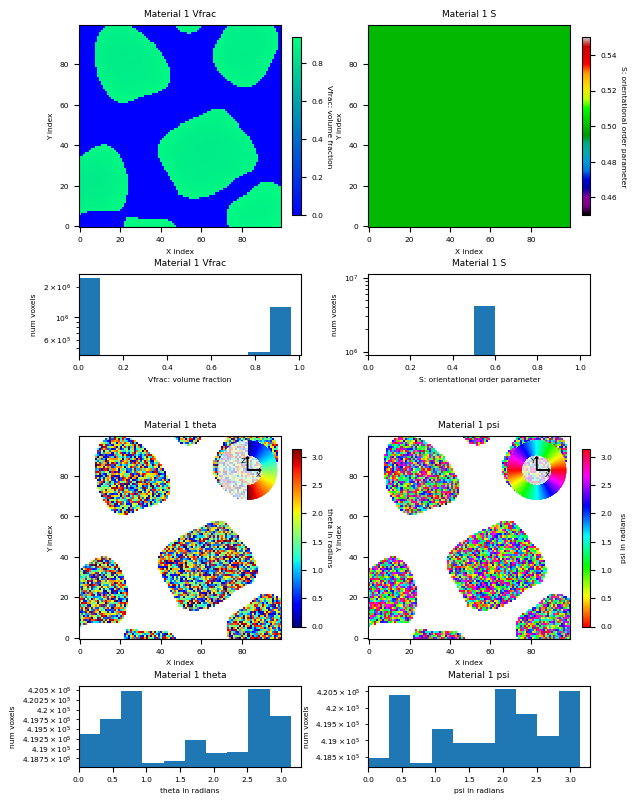

Material 2 Vfrac. Min: 0.0 Max: 1.0
Material 2 S. Min: 0.5 Max: 0.5
Material 2 theta. Min: 1.4191397999504347e-06 Max: 3.1415916433346363
Material 2 psi. Min: 4.870267378601407e-07 Max: 3.1415923336804368


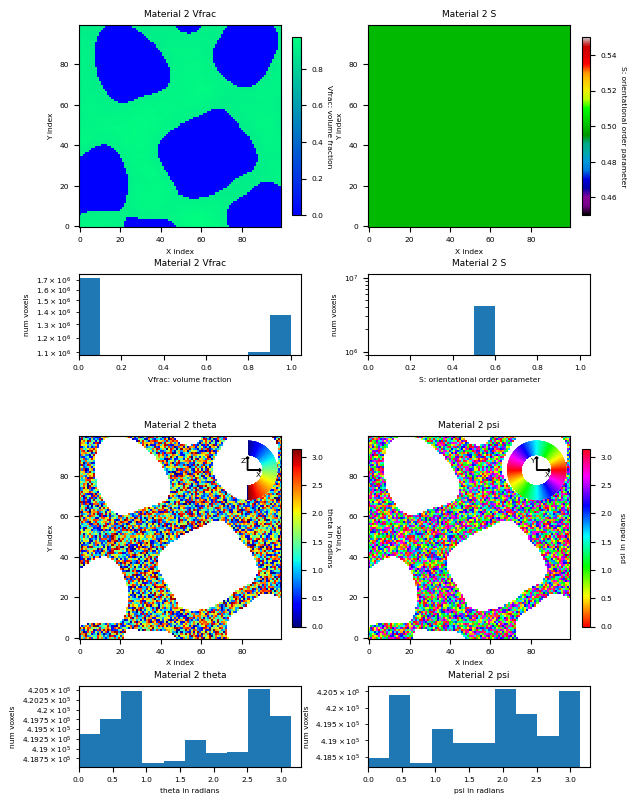

Material 3 Vfrac. Min: 0.0 Max: 0.14980599099798217
Material 3 S. Min: 0.0 Max: 0.0
Material 3 theta. Min: 0.0 Max: 0.0
Material 3 psi. Min: 0.0 Max: 0.0


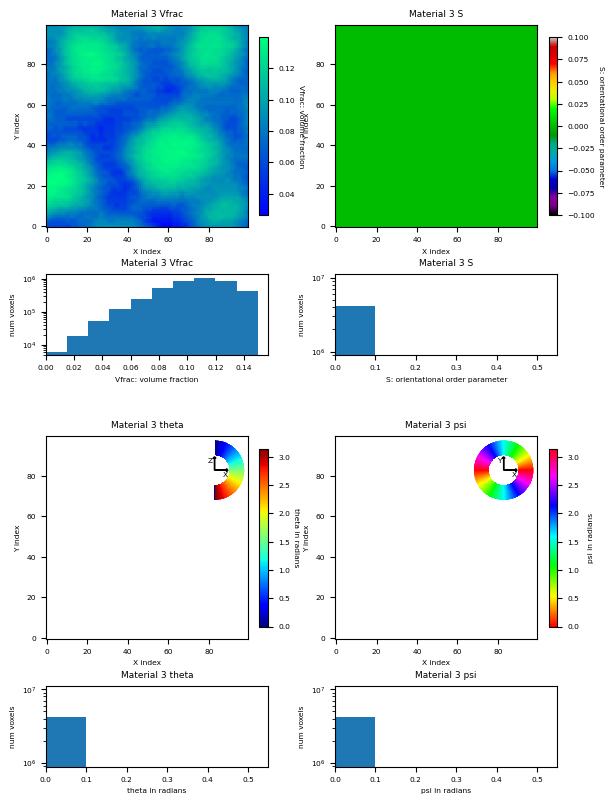

Total Vfrac whole model. Min: 1.0 Max: 1.0
0:00:07.066569


In [6]:
# now we have a basic morphology. generate, save, checkh5 to make sure I have what I want
import hithru_Nov as ht
import checkh5 as chk
import os

runner = '/home/ceb10/Jan2023/testing_20230131/'

MG_Nov.save_hdf5(f'{runner}S0p5_glassy.h5', base, 1.95, 3, mformat='ZYX')
chk.checkH5(filename=f'{runner}S0p5_glassy.h5',subsample=100,scale=0.3,save_output=True,png_out_folder='/home/ceb10/Jan2023/testing_20230131/',png_out_title='testh5')

os.remove(f'{runner}S0p5_glassy.h5')

# Let's examine how changing the S here impacts I and A vs q. Do this with Euler angles scrambled and unscrambled.

In [7]:
import shutil
def run_sweep(running_directory,AFM_info,purity,sigma_blur_nm, outputTXTfolder='dummy', Euler_scrambleTF=True, S = 1.0):
    
    AFM_file = AFM_info[0]; Tsub = AFM_info[1]; h_film = AFM_info[2]; hminus = AFM_info[3]; hplus = AFM_info[4];
    block_size = AFM_info[5]; filter_size = AFM_info[6]; offset = AFM_info[7]; voxel_size = AFM_info[8]; res = AFM_info[9]

    morph, hole, matrix = base_morph_2D_purityblur(AFM_info=AFM_info,purity=purity,sigma_nm=sigma_blur_nm, default_S=S,scramble_Eulers=Euler_scrambleTF)
    os.chdir(running_directory)
    #identifier = f'{Tsub}K_{round(hTPD_nm,2)}nmTPD_{round(hDO_nm,2)}nmDO_{round(purity,2)}%pure_{round(sigma_blur_nm,2)}nmBlur{theta_deg}theta'
    if Euler_scrambleTF == True:
        identifier = f'{Tsub}K_S{S}_purity{purity}_blur{sigma_blur_nm}nm_scrambled'
    elif Euler_scrambleTF == False:    
        identifier = f'{Tsub}K_S{S}_purity{purity}_blur{sigma_blur_nm}nm_aligned'
    
    ht.reset_dir(f'{running_directory}/{identifier}/')
    
    MG_Nov.save_hdf5(f'{running_directory}/{identifier}/{identifier}_glassy.h5', morph, 1.95, 3, mformat='ZYX')
        
    os.symlink(f'{running_directory}/config.txt',f'{running_directory}/{identifier}/config.txt')
    os.symlink(f'{running_directory}/Material1.txt',f'{running_directory}/{identifier}/Material1.txt')
    os.symlink(f'{running_directory}/Material2.txt',f'{running_directory}/{identifier}/Material2.txt')
    os.symlink(f'{running_directory}/Material3.txt',f'{running_directory}/{identifier}/Material3.txt')
    
    
    os.chdir(running_directory)
    #ht.runslurm_cb(running_directory,identifier,'cbscript.sh',f'{identifier}_glassy.h5','temp.nc')
    ht.runslurm_cb(running_directory,identifier,'cbscript.sh',f'{identifier}_glassy.h5','temp.nc')
    
#     mse = quick_Ifit_test(NCfile=f'{running_directory}/{identifier}/temp.nc',expt_file=experimental,energy=270.0,Tsub=Tsub,noisefloor=noisefloor,outputPNGfolder=outputPNGfolder,
#                          purity=purity, sigma_nm=sigma_blur_nm,ID=identifier)
    #print(f'{running_directory}/{identifier}/temp.nc')
    os.chdir(f'{running_directory}{identifier}/')
    #E,A = AvsE_textout(NCfile=f'{running_directory}{identifier}/temp.nc',Tsub=Tsub,identifier=identifier,save_directory=outputTXTfolder)
    
    # substitute with an output of I vs q and A vs q
    
    q, I, A = Iq_Aq('temp.nc',energy=284.0,identifier=identifier,savetxt=True)
        
    try:
        shutil.rmtree(f'{running_directory}/{identifier}')
    except OSError:
        pass
    # deleted the directory
    return

In [18]:
from scipy.signal import savgol_filter
from time import sleep;
import xarray as xr

def Iq_Aq(NCfile,energy,identifier,savetxt=True,out_txt_folder='/home/ceb10/Jan2023/testing_20230131/'):
    openedNC=None; sim_energies=[]; chi_sim=[]
    print(f'Looking for {NCfile}')
    while openedNC is None:    
        if os.path.exists(NCfile):
            try:    
                openedNC = xr.open_dataarray(NCfile); #q_sim = np.asarray(openedNC['q'])
            except:
                pass
        else:
            sleep(0.5)    
            
    # simple I vs q
    q_sim = np.asarray(openedNC['q'])
    I_sim = openedNC.sel(energy=energy,chi=slice(0,360)).mean(dim='chi'); I_sim = np.asarray(I_sim)
    
    # getting A vs q; will calc I para and I perp, put only output the A vs q
    I_para = openedNC.sel(energy=energy,chi=slice(0,45)).mean(dim='chi'); I_para = np.asarray(I_para)
    I_perp = openedNC.sel(energy=energy,chi=slice(45,90)).mean(dim='chi'); I_perp = np.asarray(I_perp)
    I_par_filt = savgol_filter(I_para,21,3); I_perp_filt = savgol_filter(I_perp,21,3)
    A = (I_par_filt-I_perp_filt)/(I_par_filt+I_perp_filt)
    
    IAvsq = np.column_stack((q_sim,I_sim))
    IAvsq = np.column_stack((IAvsq,A))
    
    if savetxt == True:
        np.savetxt(f'{out_txt_folder}IAvsq_{identifier}_{energy}eV.txt',IAvsq)
        
    return q_sim, I_sim, A

In [9]:
run_sweep('/home/ceb10/Jan2023/',AFM_info_310,100.,2.,outputTXTfolder='/home/ceb10/Jan2023/testing_20230131/',Euler_scrambleTF=True, S=0.7)

Assigned S = 0.7 to all voxels
Submitted batch job 537220
Looking for temp.nc


KeyboardInterrupt: 

### To do our sweep for isotropic ones - let's do values of S from 0 to 1, in increments of 0.2. We'll do purity at 0.5 and 1.0, and sigma blurs of 0.0 and 4.0. Scrambled and unscrambled.

In [11]:
Ss = np.linspace(0.0,1.0,6)
purities = [50.,100.]
blurs = [0.0,4.0]

total_sweeps = np.size(Ss)*np.size(purities)*np.size(blurs)*2

for S in Ss:
    for p in purities:
        for b in blurs:
            ts = time.time()
            run_sweep('/home/ceb10/Jan2023/',AFM_info_310,purity=p,sigma_blur_nm=b,outputTXTfolder='/home/ceb10/Jan2023/testing_20230131/',Euler_scrambleTF=True,S=S)
            ts = time.time() - ts
            print(f'{ts} seconds per sweep, or {total_sweeps*ts} seconds for the full execution')
            run_sweep('/home/ceb10/Jan2023/',AFM_info_310,purity=p,sigma_blur_nm=b,outputTXTfolder='/home/ceb10/Jan2023/testing_20230131/',Euler_scrambleTF=False,S=S)

            
# trying some other tricks

NameError: name 'time' is not defined

In [21]:
def run_sweep_tricks(running_directory,AFM_info,purity,sigma_blur_nm, outputTXTfolder='dummy', theta_scrambleTF=True, psi_scrambleTF = True, S = 1.0, theta_set=0., psi_set=0.):
    
    AFM_file = AFM_info[0]; Tsub = AFM_info[1]; h_film = AFM_info[2]; hminus = AFM_info[3]; hplus = AFM_info[4];
    block_size = AFM_info[5]; filter_size = AFM_info[6]; offset = AFM_info[7]; voxel_size = AFM_info[8]; res = AFM_info[9]

    #morph, hole, matrix = base_morph_2D_purityblur(AFM_info=AFM_info,purity=purity,sigma_nm=sigma_blur_nm, default_S=S,scramble_Eulers=Euler_scrambleTF)
    morph, hole, matrix = base_morph_tricks(AFM_info=AFM_info,purity=purity,sigma_nm=sigma_blur_nm, default_S=S,scramble_theta=theta_scrambleTF,scramble_psi=psi_scrambleTF,theta_set=theta_set,psi_set=psi_set)
    os.chdir(running_directory)
    #identifier = f'{Tsub}K_{round(hTPD_nm,2)}nmTPD_{round(hDO_nm,2)}nmDO_{round(purity,2)}%pure_{round(sigma_blur_nm,2)}nmBlur{theta_deg}theta'
    
    scramble_condition = ''
    
    if (theta_scrambleTF == True) and (psi_scrambleTF == True):
        scramble_condition = 'all_scrambled'
    elif (theta_scrambleTF == True) and (psi_scrambleTF == False):
        scramble_condition = f'randomtheta_psi{np.round(psi_set*180./np.pi, 2)}'
    elif (theta_scrambleTF == False) and (psi_scrambleTF == True):
        scramble_condition = f'theta{np.round(theta_set*180./np.pi, 2)}_randompsi'
    elif (theta_scrambleTF == False) and (psi_scrambleTF == False):
        scramble_condition = f'theta{np.round(theta_set*180./np.pi, 2)}_psi{np.round(psi_set*180./np.pi, 2)}'
        
    identifier = f'{Tsub}K_S{S}_purity{purity}_blur{sigma_blur_nm}nm_{scramble_condition}'
    
    ht.reset_dir(f'{running_directory}/{identifier}/')
    
    MG_Nov.save_hdf5(f'{running_directory}/{identifier}/{identifier}_glassy.h5', morph, 1.95, 3, mformat='ZYX')
        
    os.symlink(f'{running_directory}/config.txt',f'{running_directory}/{identifier}/config.txt')
    os.symlink(f'{running_directory}/Material1.txt',f'{running_directory}/{identifier}/Material1.txt')
    os.symlink(f'{running_directory}/Material2.txt',f'{running_directory}/{identifier}/Material2.txt')
    os.symlink(f'{running_directory}/Material3.txt',f'{running_directory}/{identifier}/Material3.txt')
    
    
    os.chdir(running_directory)
    #ht.runslurm_cb(running_directory,identifier,'cbscript.sh',f'{identifier}_glassy.h5','temp.nc')
    ht.runslurm_cb(running_directory,identifier,'cbscript.sh',f'{identifier}_glassy.h5','temp.nc')
    
#     mse = quick_Ifit_test(NCfile=f'{running_directory}/{identifier}/temp.nc',expt_file=experimental,energy=270.0,Tsub=Tsub,noisefloor=noisefloor,outputPNGfolder=outputPNGfolder,
#                          purity=purity, sigma_nm=sigma_blur_nm,ID=identifier)
    #print(f'{running_directory}/{identifier}/temp.nc')
    os.chdir(f'{running_directory}{identifier}/')
    #E,A = AvsE_textout(NCfile=f'{running_directory}{identifier}/temp.nc',Tsub=Tsub,identifier=identifier,save_directory=outputTXTfolder)
    
    # substitute with an output of I vs q and A vs q
    
    q, I, A = Iq_Aq(f'{running_directory}{identifier}/temp.nc',out_txt_folder = '/home/ceb10/Jan2023/testing_20230131/crazies/', energy=284.0,identifier=identifier,savetxt=True)
        
    try:
        shutil.rmtree(f'{running_directory}/{identifier}')
    except OSError:
        pass
    # deleted the directory
    return

## Run this when you get in on 2/1/23

In [22]:
run_sweep_tricks('/home/ceb10/Jan2023/', AFM_info_310, purity=100., sigma_blur_nm = 0.,outputTXTfolder='/home/ceb10/Jan2023/testing_20230131/crazies/', theta_scrambleTF=False, psi_scrambleTF=True,theta_set=np.pi/2.)

Assigned S = 1.0 to all voxels
Submitted batch job 537223
Looking for /home/ceb10/Jan2023/310K_S1.0_purity100.0_blur0.0nm_theta90.0_randompsi/temp.nc


<ipython-input-18-c61e5142c560>:25: RuntimeWarning: invalid value encountered in true_divide
  A = (I_par_filt-I_perp_filt)/(I_par_filt+I_perp_filt)


In [23]:
# running the set
# Try S = 1, S = 0.5
# try a 0., 1., 2., and 4. nm interfacial blur
# run at 50% and 100% purity
Ss = [0.5, 1.0]
blurs = [0., 1., 2., 4.]
purity = [50.,100.]
angles = [0., np.pi/3, np.pi/4, 2*np.pi/3, np.pi/2]

for s in Ss:
    for b in blurs:
        for p in purities:
            for a in angles:
                run_sweep_tricks('/home/ceb10/Jan2023/', AFM_info_310, purity=p, sigma_blur_nm = b,outputTXTfolder='/home/ceb10/Jan2023/testing_20230131/crazies/', theta_scrambleTF=False, psi_scrambleTF=True,theta_set=a)
                #run_sweep_tricks('/home/ceb10/Jan2023/', AFM_info_310, purity=p, sigma_blur_nm = b,outputTXTfolder='/home/ceb10/Jan2023/testing_20230131/crazies/', theta_scrambleTF=False, psi_scrambleTF=True,psi_set=a) # don't need to run through all psi
                run_sweep_tricks('/home/ceb10/Jan2023/', AFM_info_310, purity=p, sigma_blur_nm = b,outputTXTfolder='/home/ceb10/Jan2023/testing_20230131/crazies/', theta_scrambleTF=False, psi_scrambleTF=False,theta_set=a, psi_set = np.pi/2)
                run_sweep_tricks('/home/ceb10/Jan2023/', AFM_info_310, purity=p, sigma_blur_nm = b,outputTXTfolder='/home/ceb10/Jan2023/testing_20230131/crazies/', theta_scrambleTF=True, psi_scrambleTF=False, psi_set = np.pi/2)

Assigned S = 1.0 to all voxels
Submitted batch job 537224
Looking for /home/ceb10/Jan2023/310K_S1.0_purity50.0_blur0.0nm_theta0.0_randompsi/temp.nc


<ipython-input-18-c61e5142c560>:25: RuntimeWarning: invalid value encountered in true_divide
  A = (I_par_filt-I_perp_filt)/(I_par_filt+I_perp_filt)


Assigned S = 1.0 to all voxels
Submitted batch job 537225
Looking for /home/ceb10/Jan2023/310K_S1.0_purity50.0_blur0.0nm_theta0.0_psi90.0/temp.nc


<ipython-input-18-c61e5142c560>:25: RuntimeWarning: invalid value encountered in true_divide
  A = (I_par_filt-I_perp_filt)/(I_par_filt+I_perp_filt)


Assigned S = 1.0 to all voxels
Submitted batch job 537226
Looking for /home/ceb10/Jan2023/310K_S1.0_purity50.0_blur0.0nm_randomtheta_psi90.0/temp.nc


<ipython-input-18-c61e5142c560>:25: RuntimeWarning: invalid value encountered in true_divide
  A = (I_par_filt-I_perp_filt)/(I_par_filt+I_perp_filt)


Assigned S = 1.0 to all voxels
Submitted batch job 537227
Looking for /home/ceb10/Jan2023/310K_S1.0_purity50.0_blur0.0nm_theta60.0_randompsi/temp.nc


<ipython-input-18-c61e5142c560>:25: RuntimeWarning: invalid value encountered in true_divide
  A = (I_par_filt-I_perp_filt)/(I_par_filt+I_perp_filt)


Assigned S = 1.0 to all voxels
Submitted batch job 537228
Looking for /home/ceb10/Jan2023/310K_S1.0_purity50.0_blur0.0nm_theta60.0_psi90.0/temp.nc


<ipython-input-18-c61e5142c560>:25: RuntimeWarning: invalid value encountered in true_divide
  A = (I_par_filt-I_perp_filt)/(I_par_filt+I_perp_filt)


Assigned S = 1.0 to all voxels
Submitted batch job 537229
Looking for /home/ceb10/Jan2023/310K_S1.0_purity50.0_blur0.0nm_randomtheta_psi90.0/temp.nc


<ipython-input-18-c61e5142c560>:25: RuntimeWarning: invalid value encountered in true_divide
  A = (I_par_filt-I_perp_filt)/(I_par_filt+I_perp_filt)


Assigned S = 1.0 to all voxels
Submitted batch job 537230
Looking for /home/ceb10/Jan2023/310K_S1.0_purity50.0_blur0.0nm_theta45.0_randompsi/temp.nc


<ipython-input-18-c61e5142c560>:25: RuntimeWarning: invalid value encountered in true_divide
  A = (I_par_filt-I_perp_filt)/(I_par_filt+I_perp_filt)


Assigned S = 1.0 to all voxels
Submitted batch job 537231
Looking for /home/ceb10/Jan2023/310K_S1.0_purity50.0_blur0.0nm_theta45.0_psi90.0/temp.nc


<ipython-input-18-c61e5142c560>:25: RuntimeWarning: invalid value encountered in true_divide
  A = (I_par_filt-I_perp_filt)/(I_par_filt+I_perp_filt)


Assigned S = 1.0 to all voxels
Submitted batch job 537232
Looking for /home/ceb10/Jan2023/310K_S1.0_purity50.0_blur0.0nm_randomtheta_psi90.0/temp.nc


<ipython-input-18-c61e5142c560>:25: RuntimeWarning: invalid value encountered in true_divide
  A = (I_par_filt-I_perp_filt)/(I_par_filt+I_perp_filt)


Assigned S = 1.0 to all voxels
Submitted batch job 537233
Looking for /home/ceb10/Jan2023/310K_S1.0_purity50.0_blur0.0nm_theta120.0_randompsi/temp.nc


<ipython-input-18-c61e5142c560>:25: RuntimeWarning: invalid value encountered in true_divide
  A = (I_par_filt-I_perp_filt)/(I_par_filt+I_perp_filt)


Assigned S = 1.0 to all voxels
Submitted batch job 537234
Looking for /home/ceb10/Jan2023/310K_S1.0_purity50.0_blur0.0nm_theta120.0_psi90.0/temp.nc


<ipython-input-18-c61e5142c560>:25: RuntimeWarning: invalid value encountered in true_divide
  A = (I_par_filt-I_perp_filt)/(I_par_filt+I_perp_filt)


Assigned S = 1.0 to all voxels
Submitted batch job 537235
Looking for /home/ceb10/Jan2023/310K_S1.0_purity50.0_blur0.0nm_randomtheta_psi90.0/temp.nc


<ipython-input-18-c61e5142c560>:25: RuntimeWarning: invalid value encountered in true_divide
  A = (I_par_filt-I_perp_filt)/(I_par_filt+I_perp_filt)


Assigned S = 1.0 to all voxels
Submitted batch job 537236
Looking for /home/ceb10/Jan2023/310K_S1.0_purity50.0_blur0.0nm_theta90.0_randompsi/temp.nc


<ipython-input-18-c61e5142c560>:25: RuntimeWarning: invalid value encountered in true_divide
  A = (I_par_filt-I_perp_filt)/(I_par_filt+I_perp_filt)


Assigned S = 1.0 to all voxels
Submitted batch job 537237
Looking for /home/ceb10/Jan2023/310K_S1.0_purity50.0_blur0.0nm_theta90.0_psi90.0/temp.nc


<ipython-input-18-c61e5142c560>:25: RuntimeWarning: invalid value encountered in true_divide
  A = (I_par_filt-I_perp_filt)/(I_par_filt+I_perp_filt)


Assigned S = 1.0 to all voxels
Submitted batch job 537238
Looking for /home/ceb10/Jan2023/310K_S1.0_purity50.0_blur0.0nm_randomtheta_psi90.0/temp.nc


<ipython-input-18-c61e5142c560>:25: RuntimeWarning: invalid value encountered in true_divide
  A = (I_par_filt-I_perp_filt)/(I_par_filt+I_perp_filt)


Assigned S = 1.0 to all voxels
Submitted batch job 537239
Looking for /home/ceb10/Jan2023/310K_S1.0_purity100.0_blur0.0nm_theta0.0_randompsi/temp.nc


<ipython-input-18-c61e5142c560>:25: RuntimeWarning: invalid value encountered in true_divide
  A = (I_par_filt-I_perp_filt)/(I_par_filt+I_perp_filt)


Assigned S = 1.0 to all voxels
Submitted batch job 537240
Looking for /home/ceb10/Jan2023/310K_S1.0_purity100.0_blur0.0nm_theta0.0_psi90.0/temp.nc


<ipython-input-18-c61e5142c560>:25: RuntimeWarning: invalid value encountered in true_divide
  A = (I_par_filt-I_perp_filt)/(I_par_filt+I_perp_filt)


Assigned S = 1.0 to all voxels
Submitted batch job 537241
Looking for /home/ceb10/Jan2023/310K_S1.0_purity100.0_blur0.0nm_randomtheta_psi90.0/temp.nc


<ipython-input-18-c61e5142c560>:25: RuntimeWarning: invalid value encountered in true_divide
  A = (I_par_filt-I_perp_filt)/(I_par_filt+I_perp_filt)


Assigned S = 1.0 to all voxels
Submitted batch job 537242
Looking for /home/ceb10/Jan2023/310K_S1.0_purity100.0_blur0.0nm_theta60.0_randompsi/temp.nc


<ipython-input-18-c61e5142c560>:25: RuntimeWarning: invalid value encountered in true_divide
  A = (I_par_filt-I_perp_filt)/(I_par_filt+I_perp_filt)


Assigned S = 1.0 to all voxels
Submitted batch job 537243
Looking for /home/ceb10/Jan2023/310K_S1.0_purity100.0_blur0.0nm_theta60.0_psi90.0/temp.nc


<ipython-input-18-c61e5142c560>:25: RuntimeWarning: invalid value encountered in true_divide
  A = (I_par_filt-I_perp_filt)/(I_par_filt+I_perp_filt)


Assigned S = 1.0 to all voxels
Submitted batch job 537244
Looking for /home/ceb10/Jan2023/310K_S1.0_purity100.0_blur0.0nm_randomtheta_psi90.0/temp.nc


<ipython-input-18-c61e5142c560>:25: RuntimeWarning: invalid value encountered in true_divide
  A = (I_par_filt-I_perp_filt)/(I_par_filt+I_perp_filt)


Assigned S = 1.0 to all voxels
Submitted batch job 537245
Looking for /home/ceb10/Jan2023/310K_S1.0_purity100.0_blur0.0nm_theta45.0_randompsi/temp.nc


<ipython-input-18-c61e5142c560>:25: RuntimeWarning: invalid value encountered in true_divide
  A = (I_par_filt-I_perp_filt)/(I_par_filt+I_perp_filt)


Assigned S = 1.0 to all voxels
Submitted batch job 537246
Looking for /home/ceb10/Jan2023/310K_S1.0_purity100.0_blur0.0nm_theta45.0_psi90.0/temp.nc


<ipython-input-18-c61e5142c560>:25: RuntimeWarning: invalid value encountered in true_divide
  A = (I_par_filt-I_perp_filt)/(I_par_filt+I_perp_filt)


Assigned S = 1.0 to all voxels
Submitted batch job 537247
Looking for /home/ceb10/Jan2023/310K_S1.0_purity100.0_blur0.0nm_randomtheta_psi90.0/temp.nc


<ipython-input-18-c61e5142c560>:25: RuntimeWarning: invalid value encountered in true_divide
  A = (I_par_filt-I_perp_filt)/(I_par_filt+I_perp_filt)


Assigned S = 1.0 to all voxels
Submitted batch job 537248
Looking for /home/ceb10/Jan2023/310K_S1.0_purity100.0_blur0.0nm_theta120.0_randompsi/temp.nc


<ipython-input-18-c61e5142c560>:25: RuntimeWarning: invalid value encountered in true_divide
  A = (I_par_filt-I_perp_filt)/(I_par_filt+I_perp_filt)


Assigned S = 1.0 to all voxels
Submitted batch job 537249
Looking for /home/ceb10/Jan2023/310K_S1.0_purity100.0_blur0.0nm_theta120.0_psi90.0/temp.nc


<ipython-input-18-c61e5142c560>:25: RuntimeWarning: invalid value encountered in true_divide
  A = (I_par_filt-I_perp_filt)/(I_par_filt+I_perp_filt)


Assigned S = 1.0 to all voxels
Submitted batch job 537250
Looking for /home/ceb10/Jan2023/310K_S1.0_purity100.0_blur0.0nm_randomtheta_psi90.0/temp.nc


<ipython-input-18-c61e5142c560>:25: RuntimeWarning: invalid value encountered in true_divide
  A = (I_par_filt-I_perp_filt)/(I_par_filt+I_perp_filt)


Assigned S = 1.0 to all voxels
Submitted batch job 537251
Looking for /home/ceb10/Jan2023/310K_S1.0_purity100.0_blur0.0nm_theta90.0_randompsi/temp.nc


<ipython-input-18-c61e5142c560>:25: RuntimeWarning: invalid value encountered in true_divide
  A = (I_par_filt-I_perp_filt)/(I_par_filt+I_perp_filt)


Assigned S = 1.0 to all voxels
Submitted batch job 537252
Looking for /home/ceb10/Jan2023/310K_S1.0_purity100.0_blur0.0nm_theta90.0_psi90.0/temp.nc


<ipython-input-18-c61e5142c560>:25: RuntimeWarning: invalid value encountered in true_divide
  A = (I_par_filt-I_perp_filt)/(I_par_filt+I_perp_filt)


Assigned S = 1.0 to all voxels
Submitted batch job 537253
Looking for /home/ceb10/Jan2023/310K_S1.0_purity100.0_blur0.0nm_randomtheta_psi90.0/temp.nc


<ipython-input-18-c61e5142c560>:25: RuntimeWarning: invalid value encountered in true_divide
  A = (I_par_filt-I_perp_filt)/(I_par_filt+I_perp_filt)


Assigned S = 1.0 to all voxels
Submitted batch job 537254
Looking for /home/ceb10/Jan2023/310K_S1.0_purity50.0_blur1.0nm_theta0.0_randompsi/temp.nc


<ipython-input-18-c61e5142c560>:25: RuntimeWarning: invalid value encountered in true_divide
  A = (I_par_filt-I_perp_filt)/(I_par_filt+I_perp_filt)


Assigned S = 1.0 to all voxels
Submitted batch job 537255
Looking for /home/ceb10/Jan2023/310K_S1.0_purity50.0_blur1.0nm_theta0.0_psi90.0/temp.nc


<ipython-input-18-c61e5142c560>:25: RuntimeWarning: invalid value encountered in true_divide
  A = (I_par_filt-I_perp_filt)/(I_par_filt+I_perp_filt)


Assigned S = 1.0 to all voxels
Submitted batch job 537256
Looking for /home/ceb10/Jan2023/310K_S1.0_purity50.0_blur1.0nm_randomtheta_psi90.0/temp.nc


<ipython-input-18-c61e5142c560>:25: RuntimeWarning: invalid value encountered in true_divide
  A = (I_par_filt-I_perp_filt)/(I_par_filt+I_perp_filt)


Assigned S = 1.0 to all voxels
Submitted batch job 537257
Looking for /home/ceb10/Jan2023/310K_S1.0_purity50.0_blur1.0nm_theta60.0_randompsi/temp.nc


<ipython-input-18-c61e5142c560>:25: RuntimeWarning: invalid value encountered in true_divide
  A = (I_par_filt-I_perp_filt)/(I_par_filt+I_perp_filt)


Assigned S = 1.0 to all voxels
Submitted batch job 537258
Looking for /home/ceb10/Jan2023/310K_S1.0_purity50.0_blur1.0nm_theta60.0_psi90.0/temp.nc


<ipython-input-18-c61e5142c560>:25: RuntimeWarning: invalid value encountered in true_divide
  A = (I_par_filt-I_perp_filt)/(I_par_filt+I_perp_filt)


Assigned S = 1.0 to all voxels
Submitted batch job 537259
Looking for /home/ceb10/Jan2023/310K_S1.0_purity50.0_blur1.0nm_randomtheta_psi90.0/temp.nc


<ipython-input-18-c61e5142c560>:25: RuntimeWarning: invalid value encountered in true_divide
  A = (I_par_filt-I_perp_filt)/(I_par_filt+I_perp_filt)


Assigned S = 1.0 to all voxels
Submitted batch job 537260
Looking for /home/ceb10/Jan2023/310K_S1.0_purity50.0_blur1.0nm_theta45.0_randompsi/temp.nc


<ipython-input-18-c61e5142c560>:25: RuntimeWarning: invalid value encountered in true_divide
  A = (I_par_filt-I_perp_filt)/(I_par_filt+I_perp_filt)


Assigned S = 1.0 to all voxels
Submitted batch job 537261
Looking for /home/ceb10/Jan2023/310K_S1.0_purity50.0_blur1.0nm_theta45.0_psi90.0/temp.nc


<ipython-input-18-c61e5142c560>:25: RuntimeWarning: invalid value encountered in true_divide
  A = (I_par_filt-I_perp_filt)/(I_par_filt+I_perp_filt)


Assigned S = 1.0 to all voxels
Submitted batch job 537262
Looking for /home/ceb10/Jan2023/310K_S1.0_purity50.0_blur1.0nm_randomtheta_psi90.0/temp.nc


<ipython-input-18-c61e5142c560>:25: RuntimeWarning: invalid value encountered in true_divide
  A = (I_par_filt-I_perp_filt)/(I_par_filt+I_perp_filt)


Assigned S = 1.0 to all voxels
Submitted batch job 537263
Looking for /home/ceb10/Jan2023/310K_S1.0_purity50.0_blur1.0nm_theta120.0_randompsi/temp.nc


<ipython-input-18-c61e5142c560>:25: RuntimeWarning: invalid value encountered in true_divide
  A = (I_par_filt-I_perp_filt)/(I_par_filt+I_perp_filt)


Assigned S = 1.0 to all voxels
Submitted batch job 537264
Looking for /home/ceb10/Jan2023/310K_S1.0_purity50.0_blur1.0nm_theta120.0_psi90.0/temp.nc


<ipython-input-18-c61e5142c560>:25: RuntimeWarning: invalid value encountered in true_divide
  A = (I_par_filt-I_perp_filt)/(I_par_filt+I_perp_filt)


Assigned S = 1.0 to all voxels
Submitted batch job 537265
Looking for /home/ceb10/Jan2023/310K_S1.0_purity50.0_blur1.0nm_randomtheta_psi90.0/temp.nc


<ipython-input-18-c61e5142c560>:25: RuntimeWarning: invalid value encountered in true_divide
  A = (I_par_filt-I_perp_filt)/(I_par_filt+I_perp_filt)


Assigned S = 1.0 to all voxels
Submitted batch job 537266
Looking for /home/ceb10/Jan2023/310K_S1.0_purity50.0_blur1.0nm_theta90.0_randompsi/temp.nc


<ipython-input-18-c61e5142c560>:25: RuntimeWarning: invalid value encountered in true_divide
  A = (I_par_filt-I_perp_filt)/(I_par_filt+I_perp_filt)


Assigned S = 1.0 to all voxels
Submitted batch job 537267
Looking for /home/ceb10/Jan2023/310K_S1.0_purity50.0_blur1.0nm_theta90.0_psi90.0/temp.nc


<ipython-input-18-c61e5142c560>:25: RuntimeWarning: invalid value encountered in true_divide
  A = (I_par_filt-I_perp_filt)/(I_par_filt+I_perp_filt)


Assigned S = 1.0 to all voxels
Submitted batch job 537268
Looking for /home/ceb10/Jan2023/310K_S1.0_purity50.0_blur1.0nm_randomtheta_psi90.0/temp.nc


<ipython-input-18-c61e5142c560>:25: RuntimeWarning: invalid value encountered in true_divide
  A = (I_par_filt-I_perp_filt)/(I_par_filt+I_perp_filt)


Assigned S = 1.0 to all voxels
Submitted batch job 537269
Looking for /home/ceb10/Jan2023/310K_S1.0_purity100.0_blur1.0nm_theta0.0_randompsi/temp.nc


<ipython-input-18-c61e5142c560>:25: RuntimeWarning: invalid value encountered in true_divide
  A = (I_par_filt-I_perp_filt)/(I_par_filt+I_perp_filt)


Assigned S = 1.0 to all voxels
Submitted batch job 537270
Looking for /home/ceb10/Jan2023/310K_S1.0_purity100.0_blur1.0nm_theta0.0_psi90.0/temp.nc


<ipython-input-18-c61e5142c560>:25: RuntimeWarning: invalid value encountered in true_divide
  A = (I_par_filt-I_perp_filt)/(I_par_filt+I_perp_filt)


Assigned S = 1.0 to all voxels
Submitted batch job 537271
Looking for /home/ceb10/Jan2023/310K_S1.0_purity100.0_blur1.0nm_randomtheta_psi90.0/temp.nc


<ipython-input-18-c61e5142c560>:25: RuntimeWarning: invalid value encountered in true_divide
  A = (I_par_filt-I_perp_filt)/(I_par_filt+I_perp_filt)


Assigned S = 1.0 to all voxels
Submitted batch job 537272
Looking for /home/ceb10/Jan2023/310K_S1.0_purity100.0_blur1.0nm_theta60.0_randompsi/temp.nc


<ipython-input-18-c61e5142c560>:25: RuntimeWarning: invalid value encountered in true_divide
  A = (I_par_filt-I_perp_filt)/(I_par_filt+I_perp_filt)


Assigned S = 1.0 to all voxels
Submitted batch job 537273
Looking for /home/ceb10/Jan2023/310K_S1.0_purity100.0_blur1.0nm_theta60.0_psi90.0/temp.nc


<ipython-input-18-c61e5142c560>:25: RuntimeWarning: invalid value encountered in true_divide
  A = (I_par_filt-I_perp_filt)/(I_par_filt+I_perp_filt)


Assigned S = 1.0 to all voxels
Submitted batch job 537274
Looking for /home/ceb10/Jan2023/310K_S1.0_purity100.0_blur1.0nm_randomtheta_psi90.0/temp.nc


<ipython-input-18-c61e5142c560>:25: RuntimeWarning: invalid value encountered in true_divide
  A = (I_par_filt-I_perp_filt)/(I_par_filt+I_perp_filt)


Assigned S = 1.0 to all voxels
Submitted batch job 537275
Looking for /home/ceb10/Jan2023/310K_S1.0_purity100.0_blur1.0nm_theta45.0_randompsi/temp.nc


KeyboardInterrupt: 

In [30]:
Ss = [0.5, 1.0]
blurs = [0., 1., 2., 4.]
purity = [50.,100.]
#angles = [0., np.pi/3, np.pi/4, 2*np.pi/3, np.pi/2]
angles = [np.pi/6]

for s in Ss:
    for b in blurs:
        for p in purities:
            for a in angles:
                run_sweep_tricks('/home/ceb10/Jan2023/', AFM_info_310, purity=p, sigma_blur_nm = b,outputTXTfolder='/home/ceb10/Jan2023/testing_20230131/crazies/', S = s, theta_scrambleTF=False, psi_scrambleTF=True,theta_set=a)
                #run_sweep_tricks('/home/ceb10/Jan2023/', AFM_info_310, purity=p, sigma_blur_nm = b,outputTXTfolder='/home/ceb10/Jan2023/testing_20230131/crazies/', theta_scrambleTF=False, psi_scrambleTF=True,psi_set=a) # don't need to run through all psi
                run_sweep_tricks('/home/ceb10/Jan2023/', AFM_info_310, purity=p, sigma_blur_nm = b,outputTXTfolder='/home/ceb10/Jan2023/testing_20230131/crazies/', S = s, theta_scrambleTF=False, psi_scrambleTF=False,theta_set=a, psi_set = np.pi/2)
            #run_sweep_tricks('/home/ceb10/Jan2023/', AFM_info_310, purity=p, sigma_blur_nm = b,outputTXTfolder='/home/ceb10/Jan2023/testing_20230131/crazies/', S = s, theta_scrambleTF=True, psi_scrambleTF=False, psi_set = np.pi/2)

Assigned S = 0.5 to all voxels
Submitted batch job 537452
Looking for /home/ceb10/Jan2023/310K_S0.5_purity50.0_blur0.0nm_theta30.0_randompsi/temp.nc


<ipython-input-18-c61e5142c560>:25: RuntimeWarning: invalid value encountered in true_divide
  A = (I_par_filt-I_perp_filt)/(I_par_filt+I_perp_filt)


Assigned S = 0.5 to all voxels
Submitted batch job 537453
Looking for /home/ceb10/Jan2023/310K_S0.5_purity50.0_blur0.0nm_theta30.0_psi90.0/temp.nc


<ipython-input-18-c61e5142c560>:25: RuntimeWarning: invalid value encountered in true_divide
  A = (I_par_filt-I_perp_filt)/(I_par_filt+I_perp_filt)


Assigned S = 0.5 to all voxels
Submitted batch job 537454
Looking for /home/ceb10/Jan2023/310K_S0.5_purity100.0_blur0.0nm_theta30.0_randompsi/temp.nc


<ipython-input-18-c61e5142c560>:25: RuntimeWarning: invalid value encountered in true_divide
  A = (I_par_filt-I_perp_filt)/(I_par_filt+I_perp_filt)


Assigned S = 0.5 to all voxels
Submitted batch job 537455
Looking for /home/ceb10/Jan2023/310K_S0.5_purity100.0_blur0.0nm_theta30.0_psi90.0/temp.nc


<ipython-input-18-c61e5142c560>:25: RuntimeWarning: invalid value encountered in true_divide
  A = (I_par_filt-I_perp_filt)/(I_par_filt+I_perp_filt)


Assigned S = 0.5 to all voxels
Submitted batch job 537456
Looking for /home/ceb10/Jan2023/310K_S0.5_purity50.0_blur1.0nm_theta30.0_randompsi/temp.nc


<ipython-input-18-c61e5142c560>:25: RuntimeWarning: invalid value encountered in true_divide
  A = (I_par_filt-I_perp_filt)/(I_par_filt+I_perp_filt)


Assigned S = 0.5 to all voxels
Submitted batch job 537457
Looking for /home/ceb10/Jan2023/310K_S0.5_purity50.0_blur1.0nm_theta30.0_psi90.0/temp.nc


<ipython-input-18-c61e5142c560>:25: RuntimeWarning: invalid value encountered in true_divide
  A = (I_par_filt-I_perp_filt)/(I_par_filt+I_perp_filt)


Assigned S = 0.5 to all voxels
Submitted batch job 537458
Looking for /home/ceb10/Jan2023/310K_S0.5_purity100.0_blur1.0nm_theta30.0_randompsi/temp.nc


<ipython-input-18-c61e5142c560>:25: RuntimeWarning: invalid value encountered in true_divide
  A = (I_par_filt-I_perp_filt)/(I_par_filt+I_perp_filt)


Assigned S = 0.5 to all voxels
Submitted batch job 537459
Looking for /home/ceb10/Jan2023/310K_S0.5_purity100.0_blur1.0nm_theta30.0_psi90.0/temp.nc


<ipython-input-18-c61e5142c560>:25: RuntimeWarning: invalid value encountered in true_divide
  A = (I_par_filt-I_perp_filt)/(I_par_filt+I_perp_filt)


Assigned S = 0.5 to all voxels
Submitted batch job 537460
Looking for /home/ceb10/Jan2023/310K_S0.5_purity50.0_blur2.0nm_theta30.0_randompsi/temp.nc


<ipython-input-18-c61e5142c560>:25: RuntimeWarning: invalid value encountered in true_divide
  A = (I_par_filt-I_perp_filt)/(I_par_filt+I_perp_filt)


Assigned S = 0.5 to all voxels
Submitted batch job 537461
Looking for /home/ceb10/Jan2023/310K_S0.5_purity50.0_blur2.0nm_theta30.0_psi90.0/temp.nc


<ipython-input-18-c61e5142c560>:25: RuntimeWarning: invalid value encountered in true_divide
  A = (I_par_filt-I_perp_filt)/(I_par_filt+I_perp_filt)


Assigned S = 0.5 to all voxels
Submitted batch job 537462
Looking for /home/ceb10/Jan2023/310K_S0.5_purity100.0_blur2.0nm_theta30.0_randompsi/temp.nc


<ipython-input-18-c61e5142c560>:25: RuntimeWarning: invalid value encountered in true_divide
  A = (I_par_filt-I_perp_filt)/(I_par_filt+I_perp_filt)


Assigned S = 0.5 to all voxels
Submitted batch job 537463
Looking for /home/ceb10/Jan2023/310K_S0.5_purity100.0_blur2.0nm_theta30.0_psi90.0/temp.nc


<ipython-input-18-c61e5142c560>:25: RuntimeWarning: invalid value encountered in true_divide
  A = (I_par_filt-I_perp_filt)/(I_par_filt+I_perp_filt)


Assigned S = 0.5 to all voxels
Submitted batch job 537464
Looking for /home/ceb10/Jan2023/310K_S0.5_purity50.0_blur4.0nm_theta30.0_randompsi/temp.nc


<ipython-input-18-c61e5142c560>:25: RuntimeWarning: invalid value encountered in true_divide
  A = (I_par_filt-I_perp_filt)/(I_par_filt+I_perp_filt)


Assigned S = 0.5 to all voxels
Submitted batch job 537465
Looking for /home/ceb10/Jan2023/310K_S0.5_purity50.0_blur4.0nm_theta30.0_psi90.0/temp.nc


<ipython-input-18-c61e5142c560>:25: RuntimeWarning: invalid value encountered in true_divide
  A = (I_par_filt-I_perp_filt)/(I_par_filt+I_perp_filt)


Assigned S = 0.5 to all voxels
Submitted batch job 537466
Looking for /home/ceb10/Jan2023/310K_S0.5_purity100.0_blur4.0nm_theta30.0_randompsi/temp.nc


<ipython-input-18-c61e5142c560>:25: RuntimeWarning: invalid value encountered in true_divide
  A = (I_par_filt-I_perp_filt)/(I_par_filt+I_perp_filt)


Assigned S = 0.5 to all voxels
Submitted batch job 537467
Looking for /home/ceb10/Jan2023/310K_S0.5_purity100.0_blur4.0nm_theta30.0_psi90.0/temp.nc


<ipython-input-18-c61e5142c560>:25: RuntimeWarning: invalid value encountered in true_divide
  A = (I_par_filt-I_perp_filt)/(I_par_filt+I_perp_filt)


Assigned S = 1.0 to all voxels
Submitted batch job 537468
Looking for /home/ceb10/Jan2023/310K_S1.0_purity50.0_blur0.0nm_theta30.0_randompsi/temp.nc


<ipython-input-18-c61e5142c560>:25: RuntimeWarning: invalid value encountered in true_divide
  A = (I_par_filt-I_perp_filt)/(I_par_filt+I_perp_filt)


Assigned S = 1.0 to all voxels
Submitted batch job 537469
Looking for /home/ceb10/Jan2023/310K_S1.0_purity50.0_blur0.0nm_theta30.0_psi90.0/temp.nc


<ipython-input-18-c61e5142c560>:25: RuntimeWarning: invalid value encountered in true_divide
  A = (I_par_filt-I_perp_filt)/(I_par_filt+I_perp_filt)


Assigned S = 1.0 to all voxels
Submitted batch job 537470
Looking for /home/ceb10/Jan2023/310K_S1.0_purity100.0_blur0.0nm_theta30.0_randompsi/temp.nc


<ipython-input-18-c61e5142c560>:25: RuntimeWarning: invalid value encountered in true_divide
  A = (I_par_filt-I_perp_filt)/(I_par_filt+I_perp_filt)


Assigned S = 1.0 to all voxels
Submitted batch job 537471
Looking for /home/ceb10/Jan2023/310K_S1.0_purity100.0_blur0.0nm_theta30.0_psi90.0/temp.nc


<ipython-input-18-c61e5142c560>:25: RuntimeWarning: invalid value encountered in true_divide
  A = (I_par_filt-I_perp_filt)/(I_par_filt+I_perp_filt)


Assigned S = 1.0 to all voxels
Submitted batch job 537472
Looking for /home/ceb10/Jan2023/310K_S1.0_purity50.0_blur1.0nm_theta30.0_randompsi/temp.nc


<ipython-input-18-c61e5142c560>:25: RuntimeWarning: invalid value encountered in true_divide
  A = (I_par_filt-I_perp_filt)/(I_par_filt+I_perp_filt)


Assigned S = 1.0 to all voxels
Submitted batch job 537473
Looking for /home/ceb10/Jan2023/310K_S1.0_purity50.0_blur1.0nm_theta30.0_psi90.0/temp.nc


<ipython-input-18-c61e5142c560>:25: RuntimeWarning: invalid value encountered in true_divide
  A = (I_par_filt-I_perp_filt)/(I_par_filt+I_perp_filt)


Assigned S = 1.0 to all voxels
Submitted batch job 537474
Looking for /home/ceb10/Jan2023/310K_S1.0_purity100.0_blur1.0nm_theta30.0_randompsi/temp.nc


<ipython-input-18-c61e5142c560>:25: RuntimeWarning: invalid value encountered in true_divide
  A = (I_par_filt-I_perp_filt)/(I_par_filt+I_perp_filt)


Assigned S = 1.0 to all voxels
Submitted batch job 537475
Looking for /home/ceb10/Jan2023/310K_S1.0_purity100.0_blur1.0nm_theta30.0_psi90.0/temp.nc


<ipython-input-18-c61e5142c560>:25: RuntimeWarning: invalid value encountered in true_divide
  A = (I_par_filt-I_perp_filt)/(I_par_filt+I_perp_filt)


Assigned S = 1.0 to all voxels
Submitted batch job 537476
Looking for /home/ceb10/Jan2023/310K_S1.0_purity50.0_blur2.0nm_theta30.0_randompsi/temp.nc


<ipython-input-18-c61e5142c560>:25: RuntimeWarning: invalid value encountered in true_divide
  A = (I_par_filt-I_perp_filt)/(I_par_filt+I_perp_filt)


Assigned S = 1.0 to all voxels
Submitted batch job 537477
Looking for /home/ceb10/Jan2023/310K_S1.0_purity50.0_blur2.0nm_theta30.0_psi90.0/temp.nc


<ipython-input-18-c61e5142c560>:25: RuntimeWarning: invalid value encountered in true_divide
  A = (I_par_filt-I_perp_filt)/(I_par_filt+I_perp_filt)


Assigned S = 1.0 to all voxels
Submitted batch job 537478
Looking for /home/ceb10/Jan2023/310K_S1.0_purity100.0_blur2.0nm_theta30.0_randompsi/temp.nc


<ipython-input-18-c61e5142c560>:25: RuntimeWarning: invalid value encountered in true_divide
  A = (I_par_filt-I_perp_filt)/(I_par_filt+I_perp_filt)


Assigned S = 1.0 to all voxels
Submitted batch job 537479
Looking for /home/ceb10/Jan2023/310K_S1.0_purity100.0_blur2.0nm_theta30.0_psi90.0/temp.nc


<ipython-input-18-c61e5142c560>:25: RuntimeWarning: invalid value encountered in true_divide
  A = (I_par_filt-I_perp_filt)/(I_par_filt+I_perp_filt)


Assigned S = 1.0 to all voxels
Submitted batch job 537480
Looking for /home/ceb10/Jan2023/310K_S1.0_purity50.0_blur4.0nm_theta30.0_randompsi/temp.nc


<ipython-input-18-c61e5142c560>:25: RuntimeWarning: invalid value encountered in true_divide
  A = (I_par_filt-I_perp_filt)/(I_par_filt+I_perp_filt)


Assigned S = 1.0 to all voxels
Submitted batch job 537481
Looking for /home/ceb10/Jan2023/310K_S1.0_purity50.0_blur4.0nm_theta30.0_psi90.0/temp.nc


<ipython-input-18-c61e5142c560>:25: RuntimeWarning: invalid value encountered in true_divide
  A = (I_par_filt-I_perp_filt)/(I_par_filt+I_perp_filt)


Assigned S = 1.0 to all voxels
Submitted batch job 537482
Looking for /home/ceb10/Jan2023/310K_S1.0_purity100.0_blur4.0nm_theta30.0_randompsi/temp.nc


<ipython-input-18-c61e5142c560>:25: RuntimeWarning: invalid value encountered in true_divide
  A = (I_par_filt-I_perp_filt)/(I_par_filt+I_perp_filt)


Assigned S = 1.0 to all voxels
Submitted batch job 537483
Looking for /home/ceb10/Jan2023/310K_S1.0_purity100.0_blur4.0nm_theta30.0_psi90.0/temp.nc


<ipython-input-18-c61e5142c560>:25: RuntimeWarning: invalid value encountered in true_divide
  A = (I_par_filt-I_perp_filt)/(I_par_filt+I_perp_filt)


In [29]:
np.pi/6 * 180/np.pi

29.999999999999996

In [17]:
NCfile = '/home/ceb10/Jan2023/310K_S1.0_purity100.0_blur0.0nm_theta180.0_randompsi/temp.nc'

from scipy.signal import savgol_filter
from time import sleep;

openedNC = xr.open_dataarray(NCfile)


# openedNC=None; sim_energies=[]; chi_sim=[]
# print(f'Looking for {NCfile}')
# print(os.path.exists(NCfile))
# while openedNC is None:    
#     if os.path.exists(NCfile):
#         try:    
#             openedNC = xr.open_dataarray(NCfile); #q_sim = np.asarray(openedNC['q'])
#         except:
#             pass
#     else:
#         sleep(0.5)    
            
    # simple I vs q
#     q_sim = np.asarray(openedNC['q'])
#     I_sim = openedNC.sel(energy=energy,chi=slice(0,360)).mean(dim='chi'); I_sim = np.asarray(I_sim)
    
#     # getting A vs q; will calc I para and I perp, put only output the A vs q
#     I_para = openedNC.sel(energy=energy,chi=slice(0,45)).mean(dim='chi'); I_para = np.asarray(I_para)
#     I_perp = openedNC.sel(energy=energy,chi=slice(45,90)).mean(dim='chi'); I_perp = np.asarray(I_perp)
#     I_par_filt = savgol_filter(I_para,21,3); I_perp_filt = savgol_filter(I_perp,21,3)
#     A = (I_par_filt-I_perp_filt)/(I_par_filt+I_perp_filt)
    
#     IAvsq = np.column_stack((q_sim,I_sim))
#     IAvsq = np.column_stack((IAvsq,A))
    
#     if savetxt == True:
#         np.savetxt(f'{out_txt_folder}IAvsq_{identifier}_{energy}eV.txt',IAvsq)
        
#     return q_sim, I_sim, A

NameError: name 'xr' is not defined

### Generated 4 cases: 2 w/ S=1 everywhere, one in which theta and psi are scrambled. 2 w/ S=0 everywhere, one in which theta and psi are scrambled.

In [8]:
runner = '/home/ceb10/Jan2023/'

identifier = ''

ht.runslurm_cb(runner,identifier,'cbscript.sh',f'{identifier}S0p5_glassy.h5','tempS0p5.nc')

Submitted batch job 537112


In [9]:
import xarray as xr
openedNC = xr.open_dataarray('tempS0p5.nc'); q_sim = np.asarray(openedNC['q'])
I_sim = openedNC.sel(energy=284.0,chi=slice(0,360)).mean(dim='chi'); I_sim = np.asarray(I_sim)

# pero, I think the most important thing to look at is anisotropy
I_para = openedNC.sel(energy=284.0,chi=slice(0,45)).mean(dim='chi'); I_paraS1 = np.asarray(I_para)
I_perp = openedNC.sel(energy=284.0,chi=slice(45,90)).mean(dim='chi'); I_perpS1 = np.asarray(I_perp)

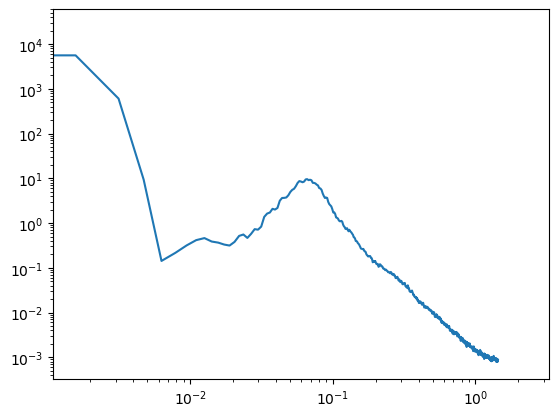

In [10]:
plt.close()
#plt.plot(q_sim,I_para)
plt.loglog()
plt.show()

<ipython-input-18-42ca679e315c>:8: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(q_sim,(I_par_filt-I_perp_filt)/(I_par_filt+I_perp_filt))


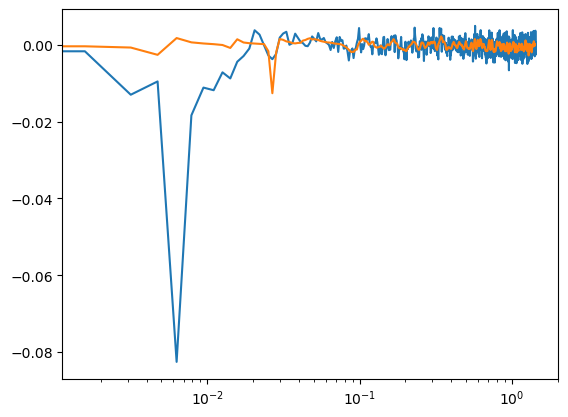

In [18]:
from scipy.signal import savgol_filter

I_par_filt = savgol_filter(I_para,31,5)
I_perp_filt = savgol_filter(I_perp,31,5)

plt.close()
plt.plot(q_sim,(I_para-I_perp)/(I_para+I_perp))
plt.plot(q_sim,(I_par_filt-I_perp_filt)/(I_par_filt+I_perp_filt))
plt.semilogx()
plt.show()

In [115]:
import xarray as xr

i = 12

energies = [270.0,272.0,274.0,276.0,278.0,280.0,282.0,282.25,282.5,282.75,283.0,283.25,283.5,283.75,284.0,284.25,284.5,284.75,285.0,
            285.25,285.5,285.75,286.0,286.5,287.0,287.5,288.0,289.0,289.5,290.0,300.0]
openedNC = xr.open_dataarray('tempS1.nc'); q_sim = np.asarray(openedNC['q'])
I_sim = openedNC.sel(energy=284.0,chi=slice(0,360)).mean(dim='chi'); I_sim = np.asarray(I_sim)

# pero, I think the most important thing to look at is anisotropy
I_para = openedNC.sel(energy=energies[i],chi=slice(0,45)).mean(dim='chi'); I_paraS1 = np.asarray(I_para)
I_perp = openedNC.sel(energy=energies[i],chi=slice(45,90)).mean(dim='chi'); I_perpS1 = np.asarray(I_perp)


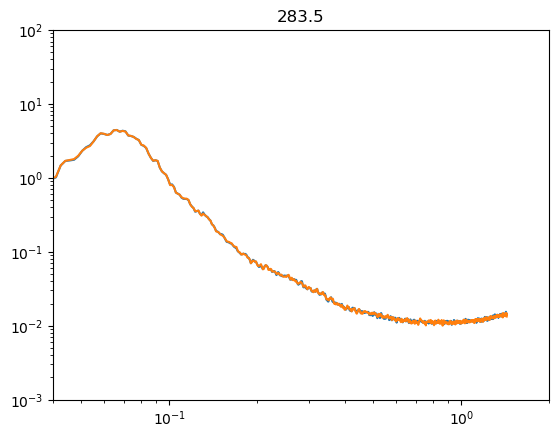

In [116]:
fig, ax = plt.subplots()
ax.plot(q_sim, I_paraS1)
ax.plot(q_sim, I_perpS1)
ax.loglog()
ax.set_xlim(0.04,2); ax.set_ylim(0.001,100)
ax.set_title(f'{energies[i]}')
plt.show()

In [65]:
ht.runslurm_cb(runner,identifier,'cbscript.sh',f'{identifier}S1_wrong_glassy.h5','tempS1_wrong.nc')

Submitted batch job 537102


In [118]:
openedNC = xr.open_dataarray('tempS1_wrong.nc'); q_sim = np.asarray(openedNC['q'])
I_sim = openedNC.sel(energy=284.0,chi=slice(0,360)).mean(dim='chi'); I_sim = np.asarray(I_sim)

# pero, I think the most important thing to look at is anisotropy
I_para = openedNC.sel(energy=energies[i],chi=slice(0,45)).mean(dim='chi'); I_paraS1_wrong = np.asarray(I_para)
I_perp = openedNC.sel(energy=energies[i],chi=slice(45,90)).mean(dim='chi'); I_perpS1_wrong = np.asarray(I_perp)

In [121]:
ht.runslurm_cb(runner,identifier,'cbscript.sh',f'{identifier}S0_glassy.h5','tempS0.nc')
#ht.runslurm_cb(runner,identifier,'cbscript.sh',f'{identifier}S0_wrong_glassy.h5','tempS0_wrong.nc')

# remember you can't run these both in a row due to wait times

Submitted batch job 537106


In [122]:
openedNC = xr.open_dataarray('tempS0.nc'); q_sim = np.asarray(openedNC['q'])
I_sim = openedNC.sel(energy=energies[i],chi=slice(0,360)).mean(dim='chi'); I_sim = np.asarray(I_sim)

# pero, I think the most important thing to look at is anisotropy
I_para = openedNC.sel(energy=energies[i],chi=slice(0,45)).mean(dim='chi'); I_paraS0 = np.asarray(I_para)
I_perp = openedNC.sel(energy=energies[i],chi=slice(45,90)).mean(dim='chi'); I_perpS0 = np.asarray(I_perp)

openedNC = xr.open_dataarray('tempS0_wrong.nc'); q_sim = np.asarray(openedNC['q'])
I_sim = openedNC.sel(energy=energies[i],chi=slice(0,360)).mean(dim='chi'); I_sim = np.asarray(I_sim)

# pero, I think the most important thing to look at is anisotropy
I_para = openedNC.sel(energy=energies[i],chi=slice(0,45)).mean(dim='chi'); I_paraS0_wrong = np.asarray(I_para)
I_perp = openedNC.sel(energy=energies[i],chi=slice(45,90)).mean(dim='chi'); I_perpS0_wrong = np.asarray(I_perp)

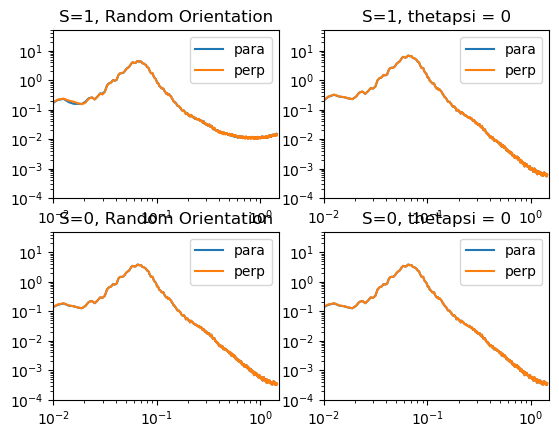

In [136]:
fig, ([ax1,ax2],[ax3,ax4]) = plt.subplots(2,2)
ax1.plot(q_sim, I_paraS1, label='para')
ax1.plot(q_sim, I_perpS1, label='perp')
ax2.plot(q_sim, I_paraS1_wrong, label='para')
ax2.plot(q_sim, I_perpS1_wrong, label='perp')

ax3.plot(q_sim, I_paraS0, label='para')
ax3.plot(q_sim, I_perpS0, label='perp')
ax4.plot(q_sim, I_paraS0_wrong, label='para')
ax4.plot(q_sim, I_perpS0_wrong, label='perp')

# ax1.set_ylim(0.005,10); ax1.set_title('S=1, Random Orientation')
# ax2.set_ylim(0.0001,50); ax2.set_title('S=1, thetapsi = 0')
# ax3.set_ylim(0.0001,50); ax3.set_title('S=0, Random Orientation')
# ax4.set_ylim(0.0001,50); ax4.set_title('S=0, thetapsi = 0')

ax1.set_title('S=1, Random Orientation')
ax2.set_title('S=1, thetapsi = 0')
ax3.set_title('S=0, Random Orientation')
ax4.set_title('S=0, thetapsi = 0')

for a in [ax1,ax2,ax3,ax4]:
    a.loglog()
    a.set_xlim(0.01,1.5)
    a.set_ylim(0.0001,50)
    a.legend()
plt.show()

### This is the opposite of encouraging. Well, let's test it out with oriented morphologies.
#### But first, let's just do one test where we have S = 0, and test out different orientations

In [139]:
from skimage import io
from skimage.color import rgb2gray
from skimage.filters import threshold_local, gaussian
import skimage

def base_morph_2D_purityblurS1tests(AFM_info, sigma_nm=0., purity=100.,static_angles=True,theta_set=0.): # theta and psi in radians
    '''
    Calculates a morphology without interfacial or out-of-plane orientation.
    
    Parameters:
    
    AFM_info: tuple consisting of (AFM_file, Tsub, h_film, hminus, hplus, block_size, filter_size, offset, voxel_size, res)
    
    sigma_nm: takes a sigma blur in nm
    
    purity: self-explanatory
    
    S_one: make S = 1 everywhere. Note that this will make a *completely* vertically aligned morphology
    
    Returns: morph_to_save, hole_binary, matrix_binary
    
    
    '''
    AFM_file = AFM_info[0]; Tsub = AFM_info[1]; h_film = AFM_info[2]; hminus = AFM_info[3]; hplus = AFM_info[4];
    block_size = AFM_info[5]; filter_size = AFM_info[6]; offset = AFM_info[7]; voxel_size = AFM_info[8]; res = AFM_info[9]
    
    holes,matrix,gray_image = process_image(AFM_file,block_size,filter_size,offset) # made filters for what is material a and what is mat b
    
    sigma_vox = sigma_nm / 1.95
    # blur holes first
    holes_blur = skimage.filters.gaussian(holes*1., sigma=(sigma_vox, sigma_vox), truncate=3., multichannel=False) # turns a boolean into a np, by the way
    matrix_blur = np.subtract(np.ones(np.shape(holes_blur),dtype=float),holes_blur)

    TPD_hole_pct = (50. + 0.5*purity)/100.; TPD_matrix_pct = (50 - 0.5*purity)/100. # turns the purity parameter into percents in hole, matrix
    DO_hole_pct = (50 - 0.5*purity)/100.; DO_matrix_pct = (50 + 0.5*purity)/100.
    
    # remember I may need to re-think purity parameter; mass balance with heights as well as the 2D surface area
    holes_TPD = holes_blur*TPD_hole_pct; holes_DO = holes_blur*DO_hole_pct
    matrix_TPD = matrix_blur*TPD_matrix_pct; matrix_DO = matrix_blur*DO_matrix_pct

    h_max = h_film+np.abs(hplus); h_min = h_film-np.abs(hminus) # accounting for vacuum fractions
    heights = (gray_image*(np.abs(hplus)+np.abs(hminus))+(h_min))       
    Vfrac_V = (h_max - heights)/h_max #volume fraction of each voxel that is vacuum
    Vfrac_M = 1. - Vfrac_V # this will turn into numbers like 0.9 - so that is the pctg of material in it. Can use that as a scale factor for the 

    all_TPD = np.add(holes_TPD,matrix_TPD); all_DO = np.add(holes_DO,matrix_DO)

    TPD_adjusted = np.multiply(Vfrac_M,all_TPD); DO_adjusted = np.multiply(Vfrac_M,all_DO)

    Vfrac_TPD = np.expand_dims(TPD_adjusted,axis=0); Vfrac_DO = np.expand_dims(DO_adjusted, axis=0) # expanding dims for compatibility with CyRSOXS (2048x2048 to 1x2048x2048)
    Vfrac_V = np.expand_dims(Vfrac_V,axis=0)

    zeros_mat = np.zeros(np.shape(Vfrac_V),dtype=float)
    ones_mat = np.ones(np.shape(Vfrac_V),dtype=float)
    
    hole_binary = holes; matrix_binary = matrix # these outputs are necessary for adding orientation later; however, this way, we only have to generate the isotropic morphology once
    # this has changed - we automatically set S to 1 everywhere. Theta and psi are automatically 0 because we haven't added orientation yet
    # HOWEVER, note that this would not actually create an "isotropic" morphology - it's completely aligned, so this is meaningless, really
    
    theta_mat = ones_mat*theta_set
    psi_mat = np.random.uniform(0.,np.pi,np.shape(Vfrac_TPD))
    

    morph_to_save = [Vfrac_TPD, ones_mat, theta_mat, psi_mat, Vfrac_DO, ones_mat, theta_mat, psi_mat, Vfrac_V, zeros_mat, zeros_mat, zeros_mat]

    return morph_to_save, hole_binary, matrix_binary


Dataset dimensions: 1 × 2048 × 2048
Number of Materials: 3

Material 1 Vfrac. Min: 0.0 Max: 0.9618914584303379
Material 1 S. Min: 1.0 Max: 1.0
Material 1 theta. Min: 1.5707963267948966 Max: 1.5707963267948966
Material 1 psi. Min: 1.4137931151859815e-07 Max: 3.1415923128891805


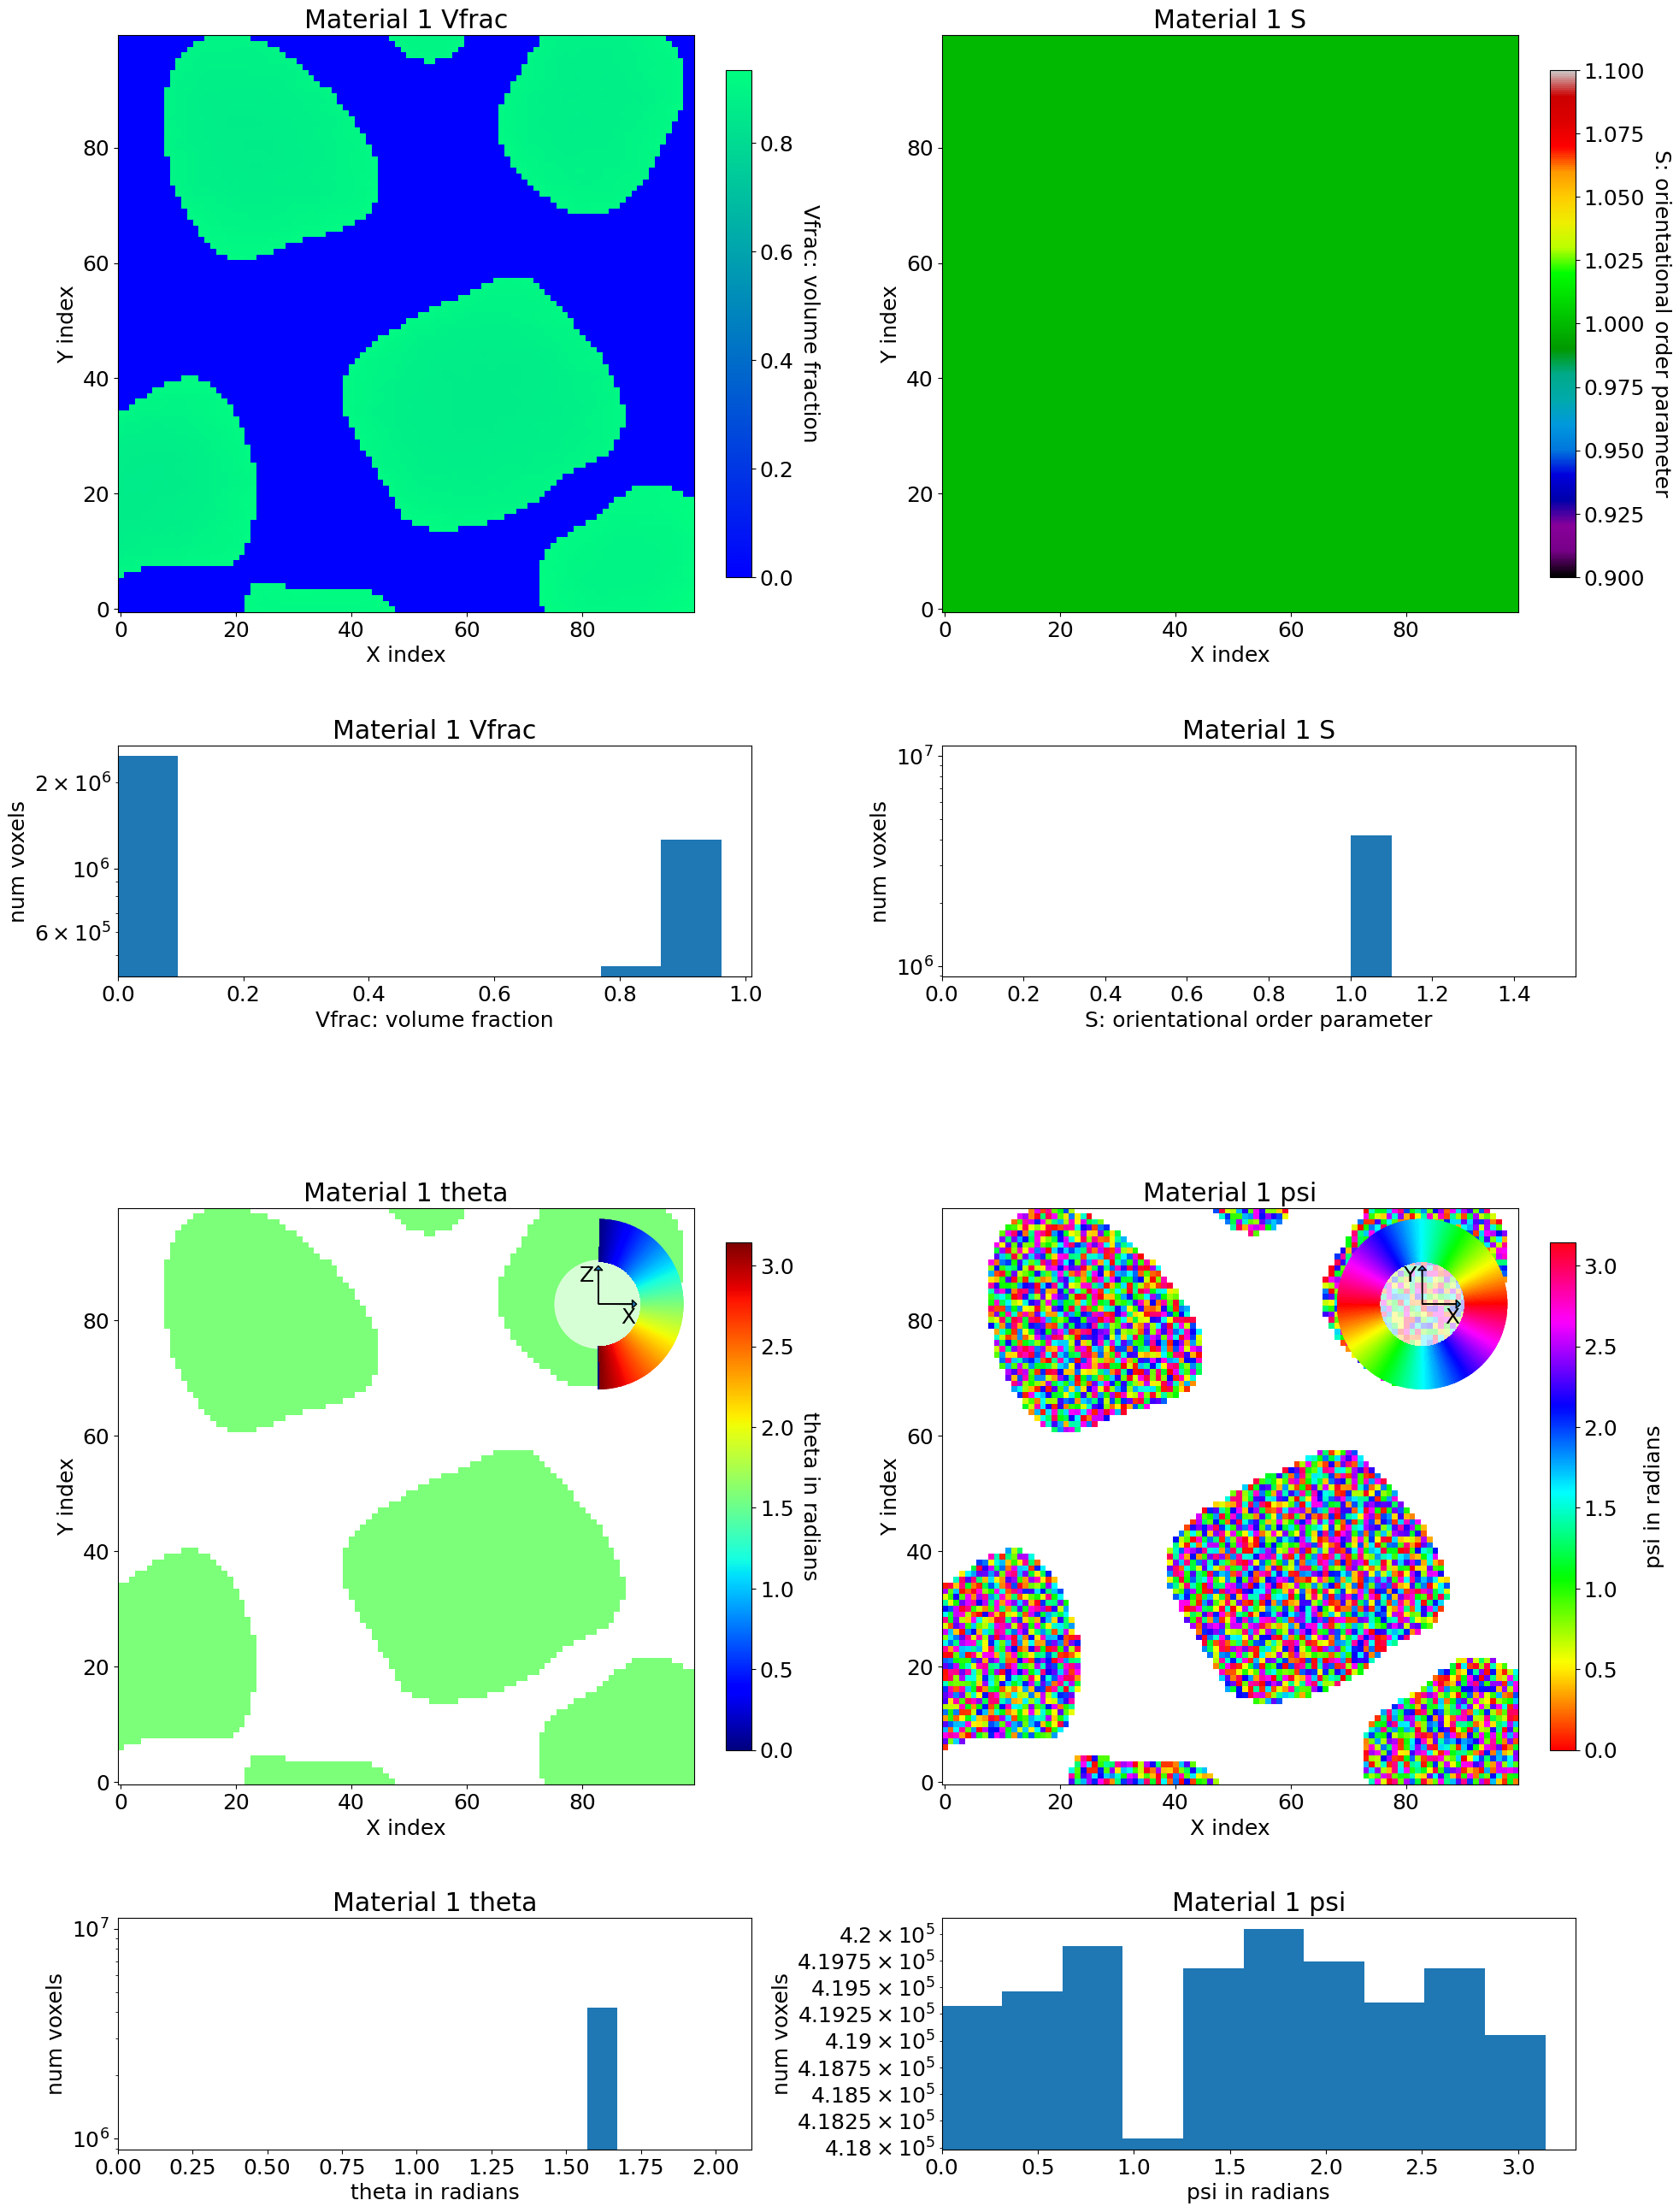

Material 2 Vfrac. Min: 0.0 Max: 1.0
Material 2 S. Min: 1.0 Max: 1.0
Material 2 theta. Min: 1.5707963267948966 Max: 1.5707963267948966
Material 2 psi. Min: 1.4137931151859815e-07 Max: 3.1415923128891805


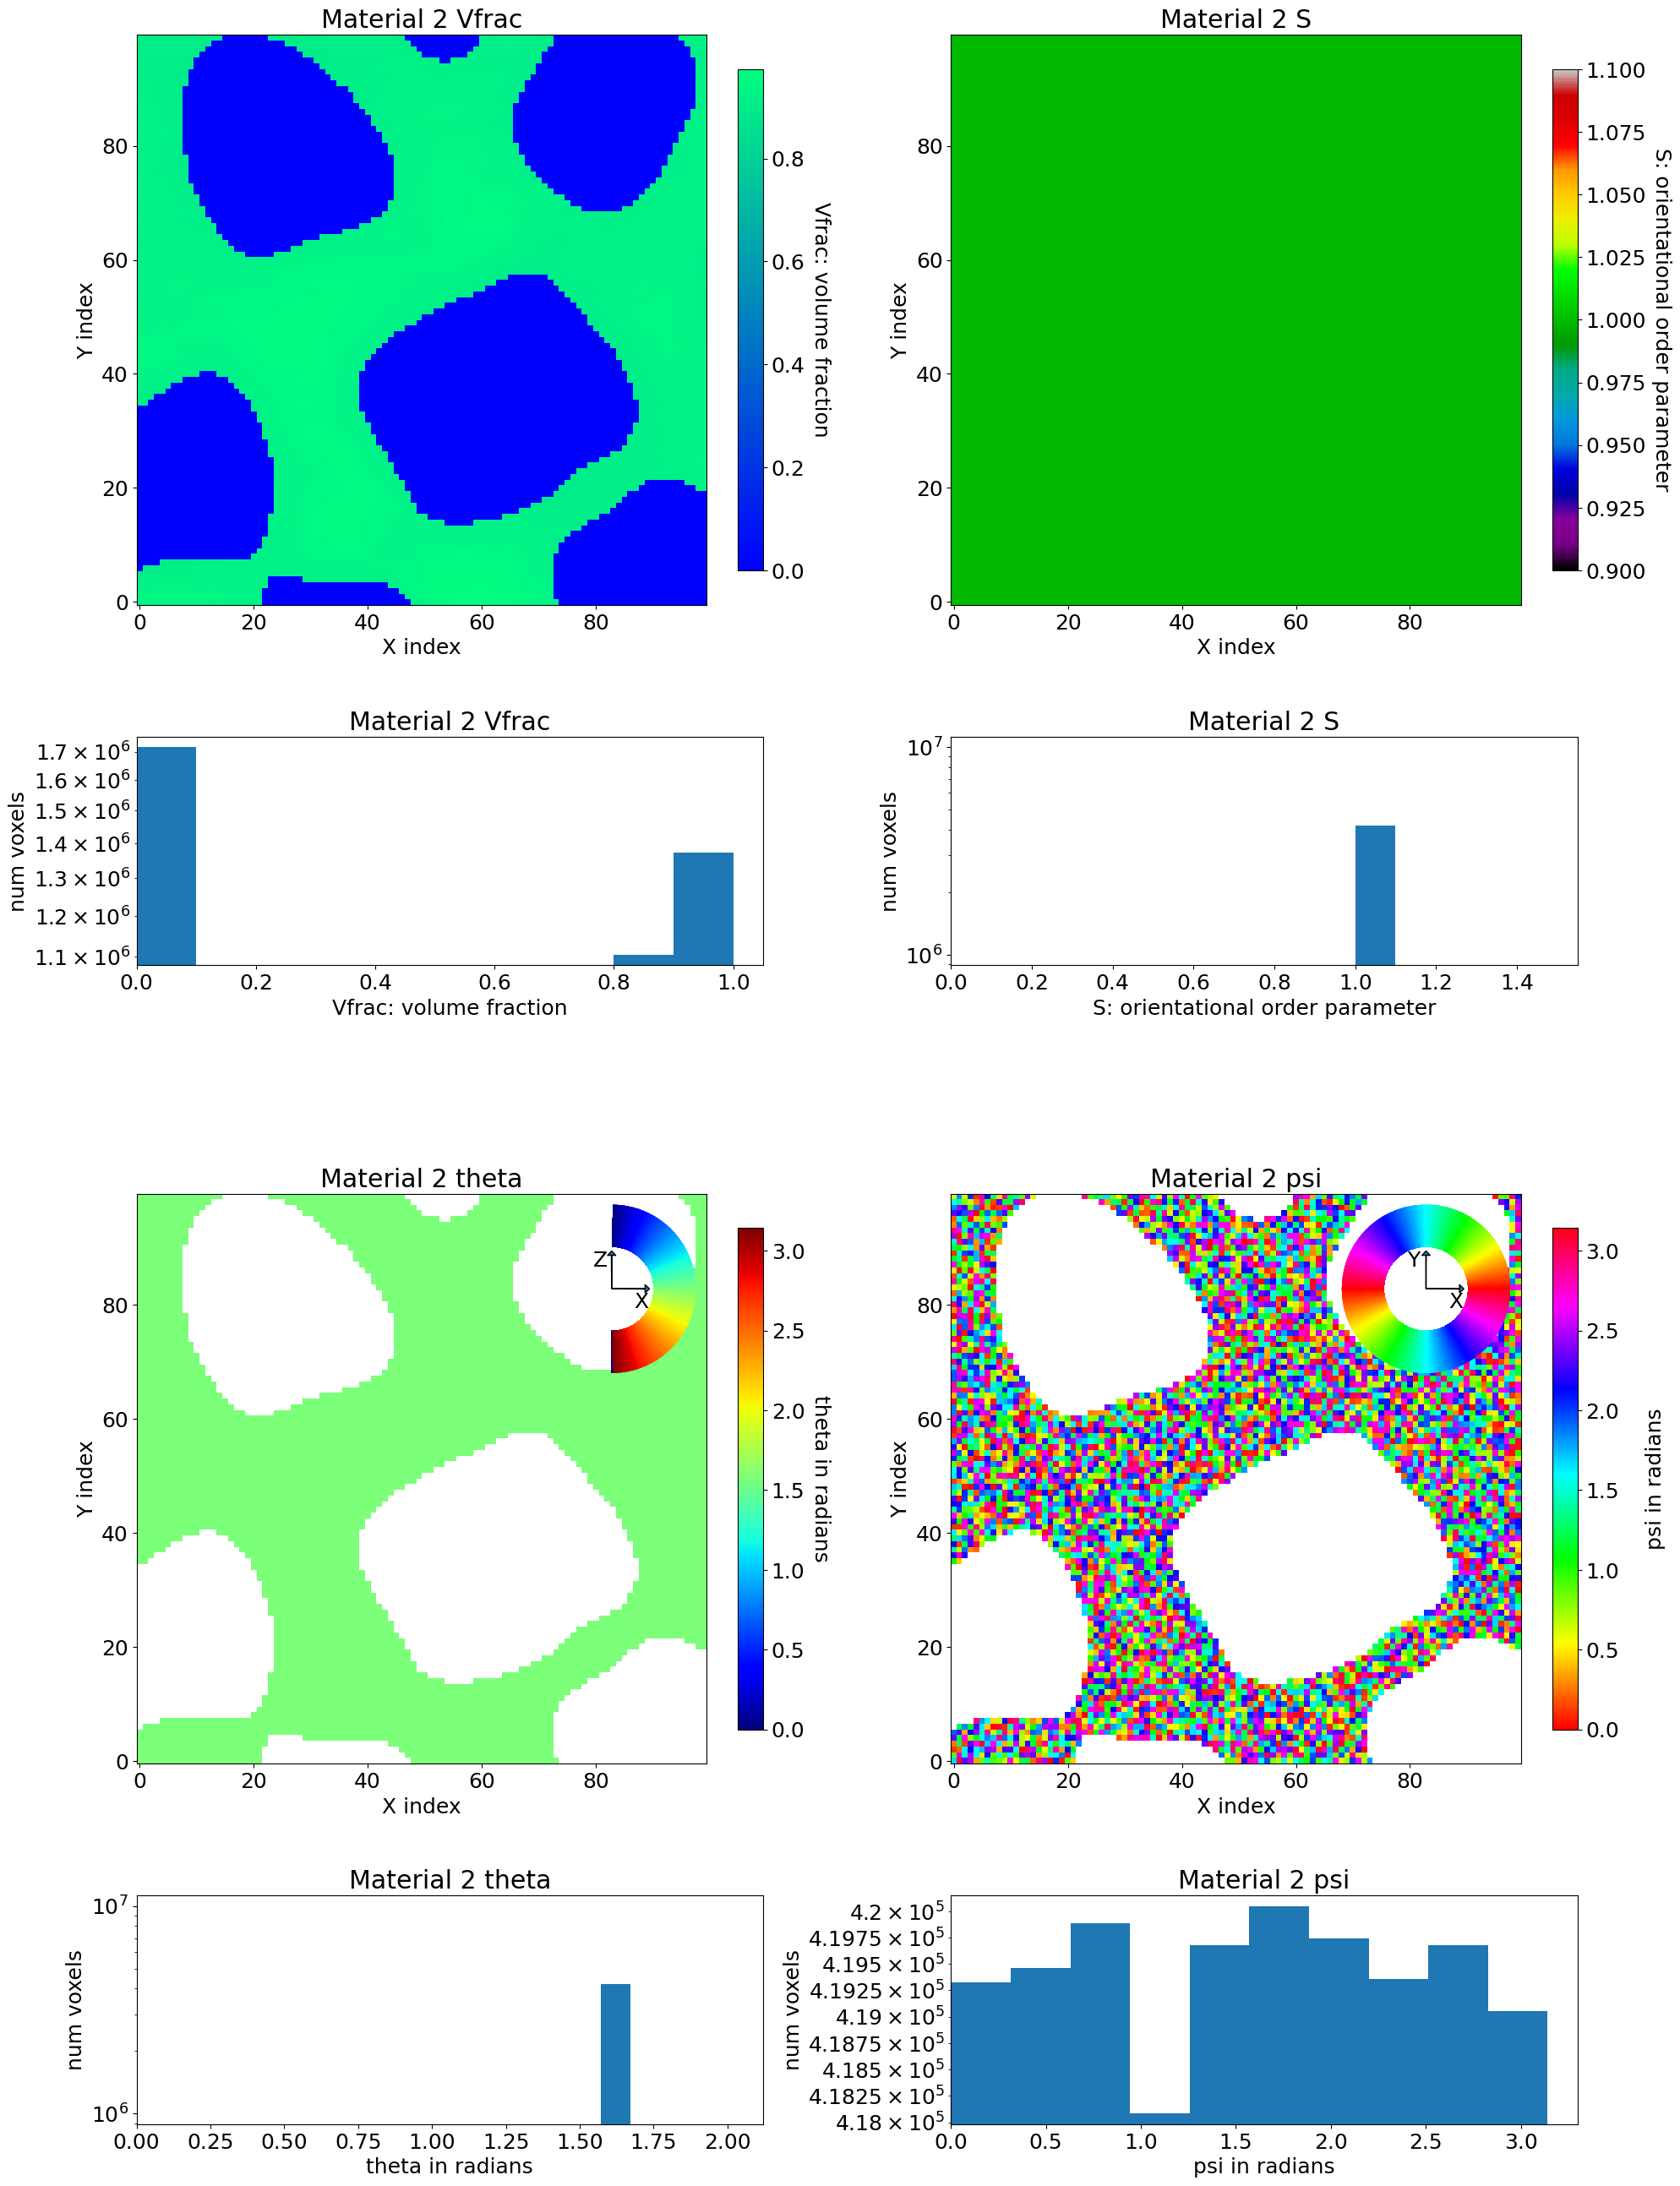

Material 3 Vfrac. Min: 0.0 Max: 0.14980599099798217
Material 3 S. Min: 0.0 Max: 0.0
Material 3 theta. Min: 0.0 Max: 0.0
Material 3 psi. Min: 0.0 Max: 0.0


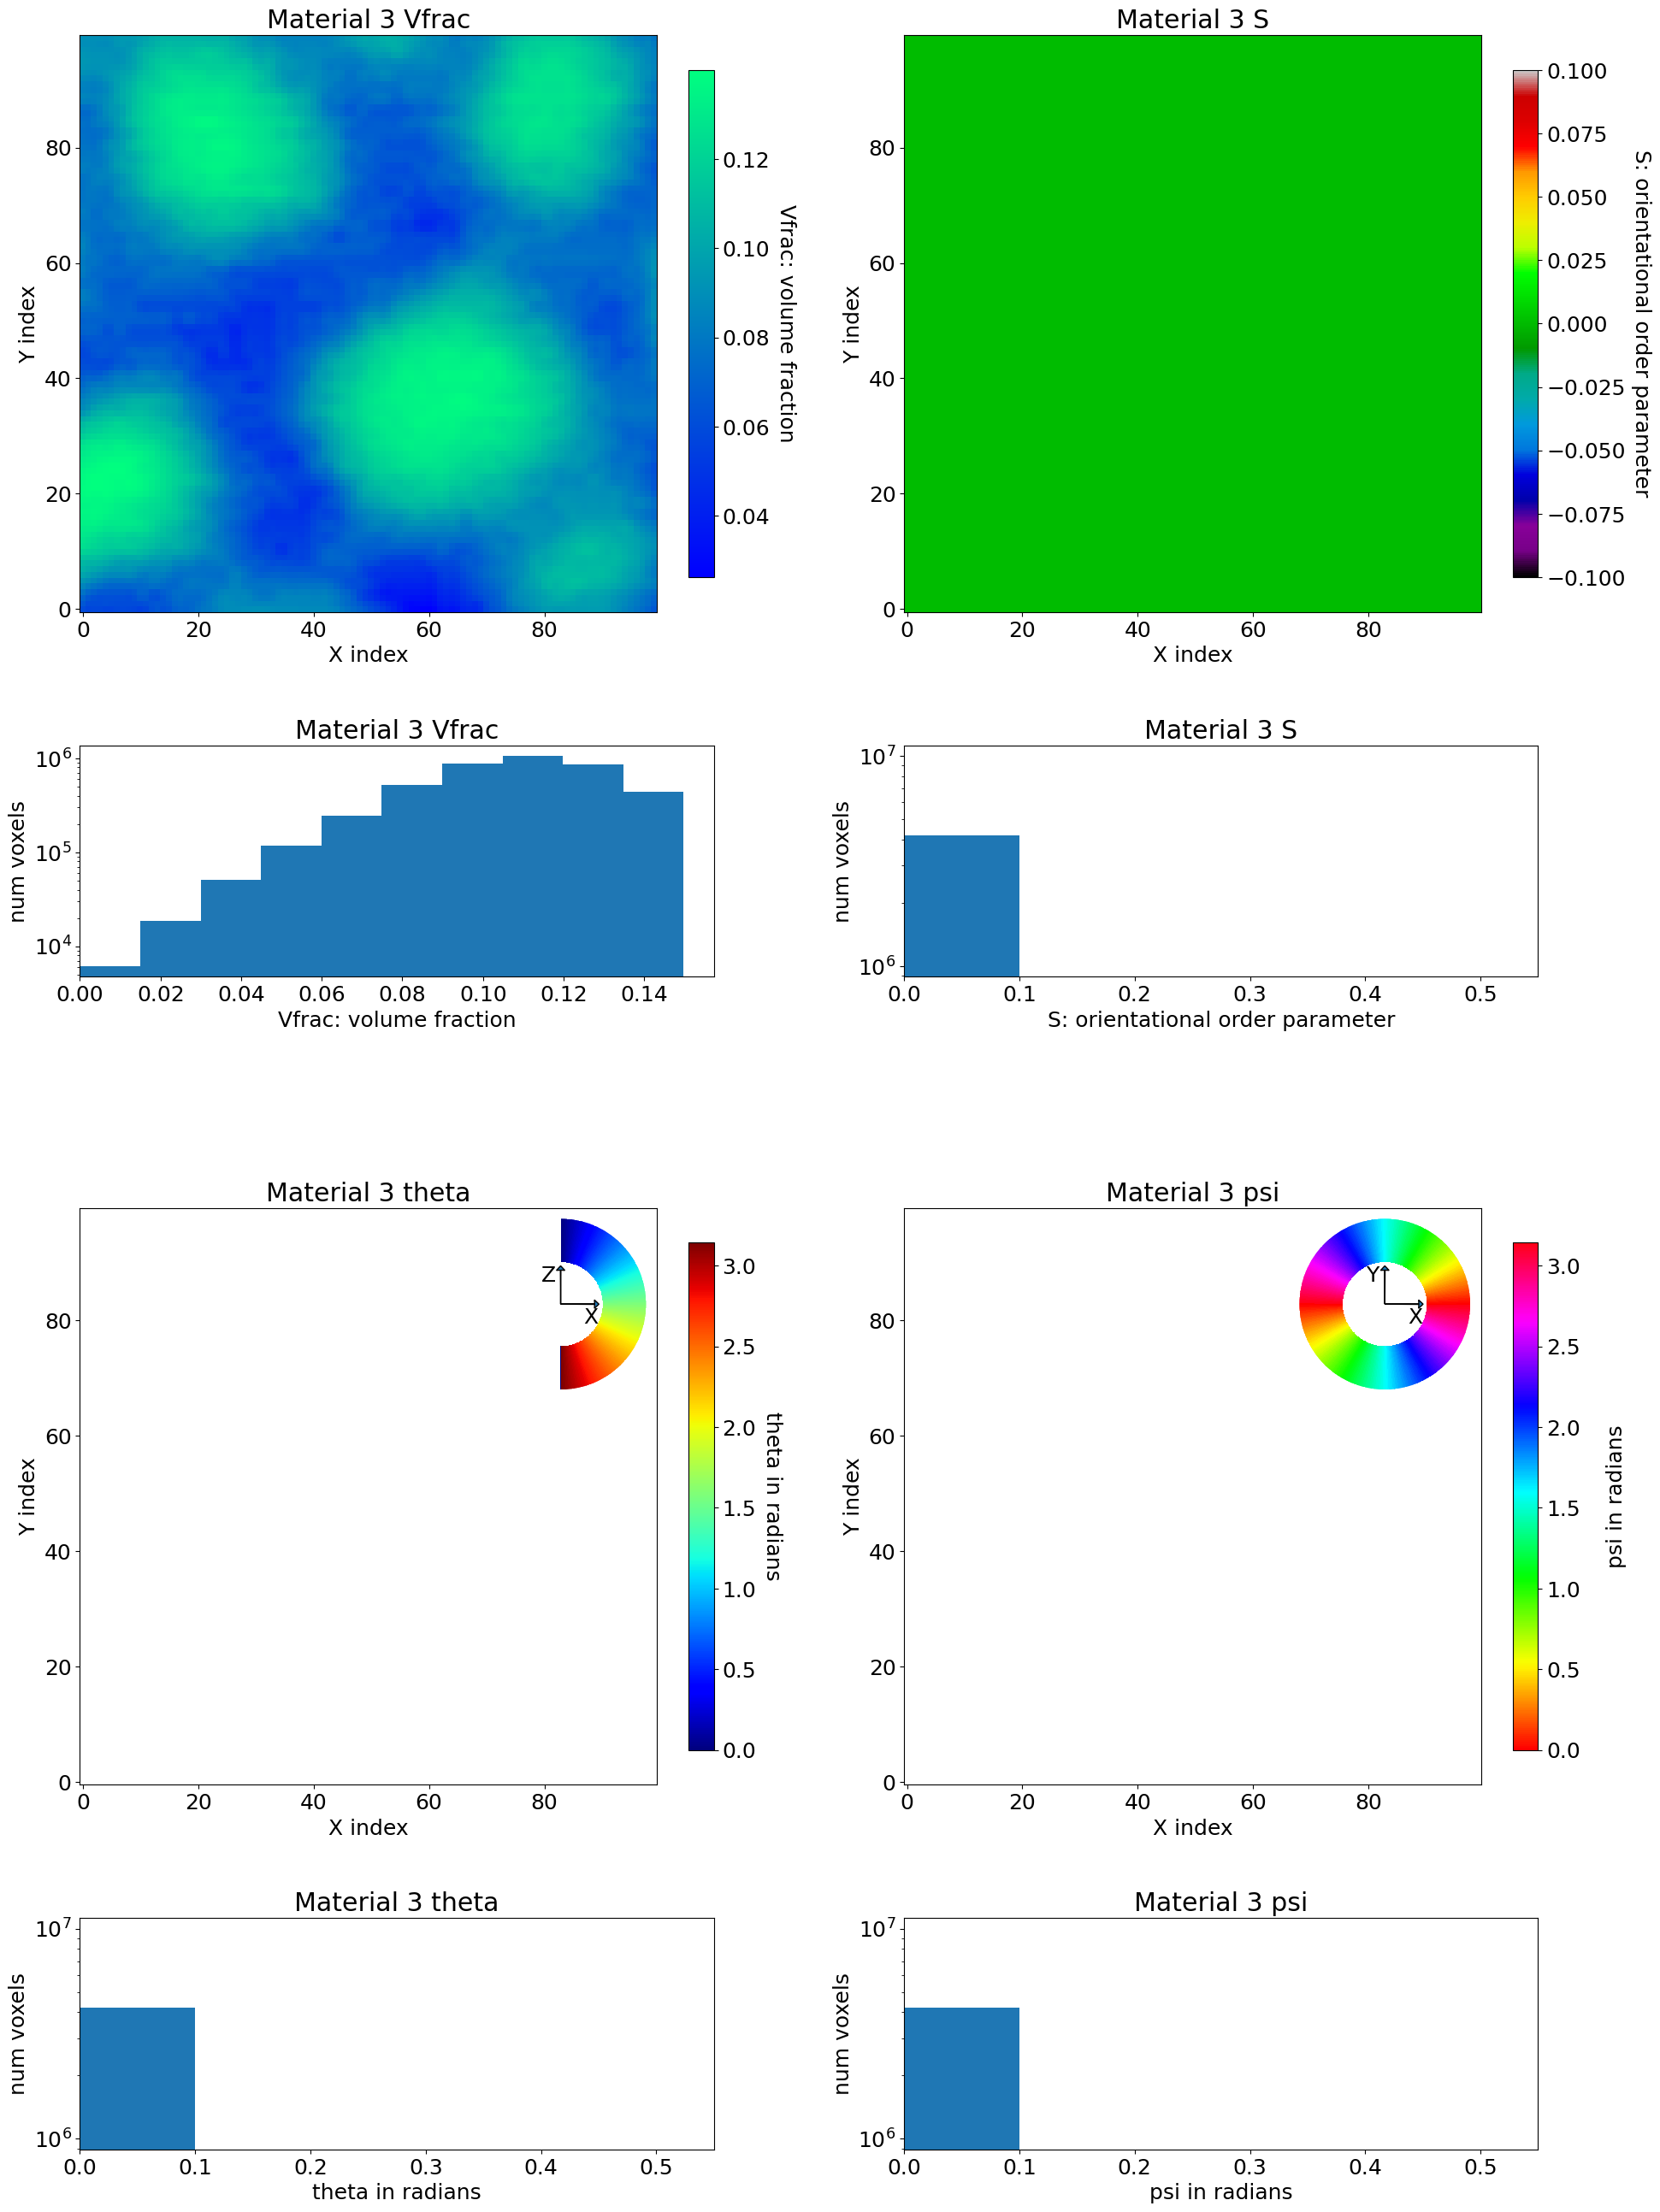

Total Vfrac whole model. Min: 1.0 Max: 1.0
0:00:07.501628


In [143]:
runner = '/home/ceb10/Jan2023/'

identifier = ''

morph, holeS1_binary, matrixS1_binary = base_morph_2D_purityblurS1tests(AFM_info_310,theta_set=np.pi/2.)

MG_Nov.save_hdf5(f'{runner}S1_theta90_glassy.h5', morph, 1.95, 3, mformat='ZYX')
chk.checkH5(filename=f'{runner}S1_theta90_glassy.h5',subsample=100)

In [144]:
ht.runslurm_cb(runner,identifier,'cbscript.sh','S1_theta90_glassy.h5','tempS1.nc')

Submitted batch job 537107


In [145]:
openedNC = xr.open_dataarray('tempS1.nc'); q_sim = np.asarray(openedNC['q'])
I_sim = openedNC.sel(energy=energies[i],chi=slice(0,360)).mean(dim='chi'); I_sim = np.asarray(I_sim)

# pero, I think the most important thing to look at is anisotropy
I_para = openedNC.sel(energy=energies[i],chi=slice(0,45)).mean(dim='chi'); I_paraS0_theta90 = np.asarray(I_para)
I_perp = openedNC.sel(energy=energies[i],chi=slice(45,90)).mean(dim='chi'); I_perpS0_theta90 = np.asarray(I_perp)


Dataset dimensions: 1 × 2048 × 2048
Number of Materials: 3

Material 1 Vfrac. Min: 0.0 Max: 0.9618914584303379
Material 1 S. Min: 1.0 Max: 1.0
Material 1 theta. Min: 0.0 Max: 0.0
Material 1 psi. Min: 5.347391427537864e-07 Max: 3.141592617272476


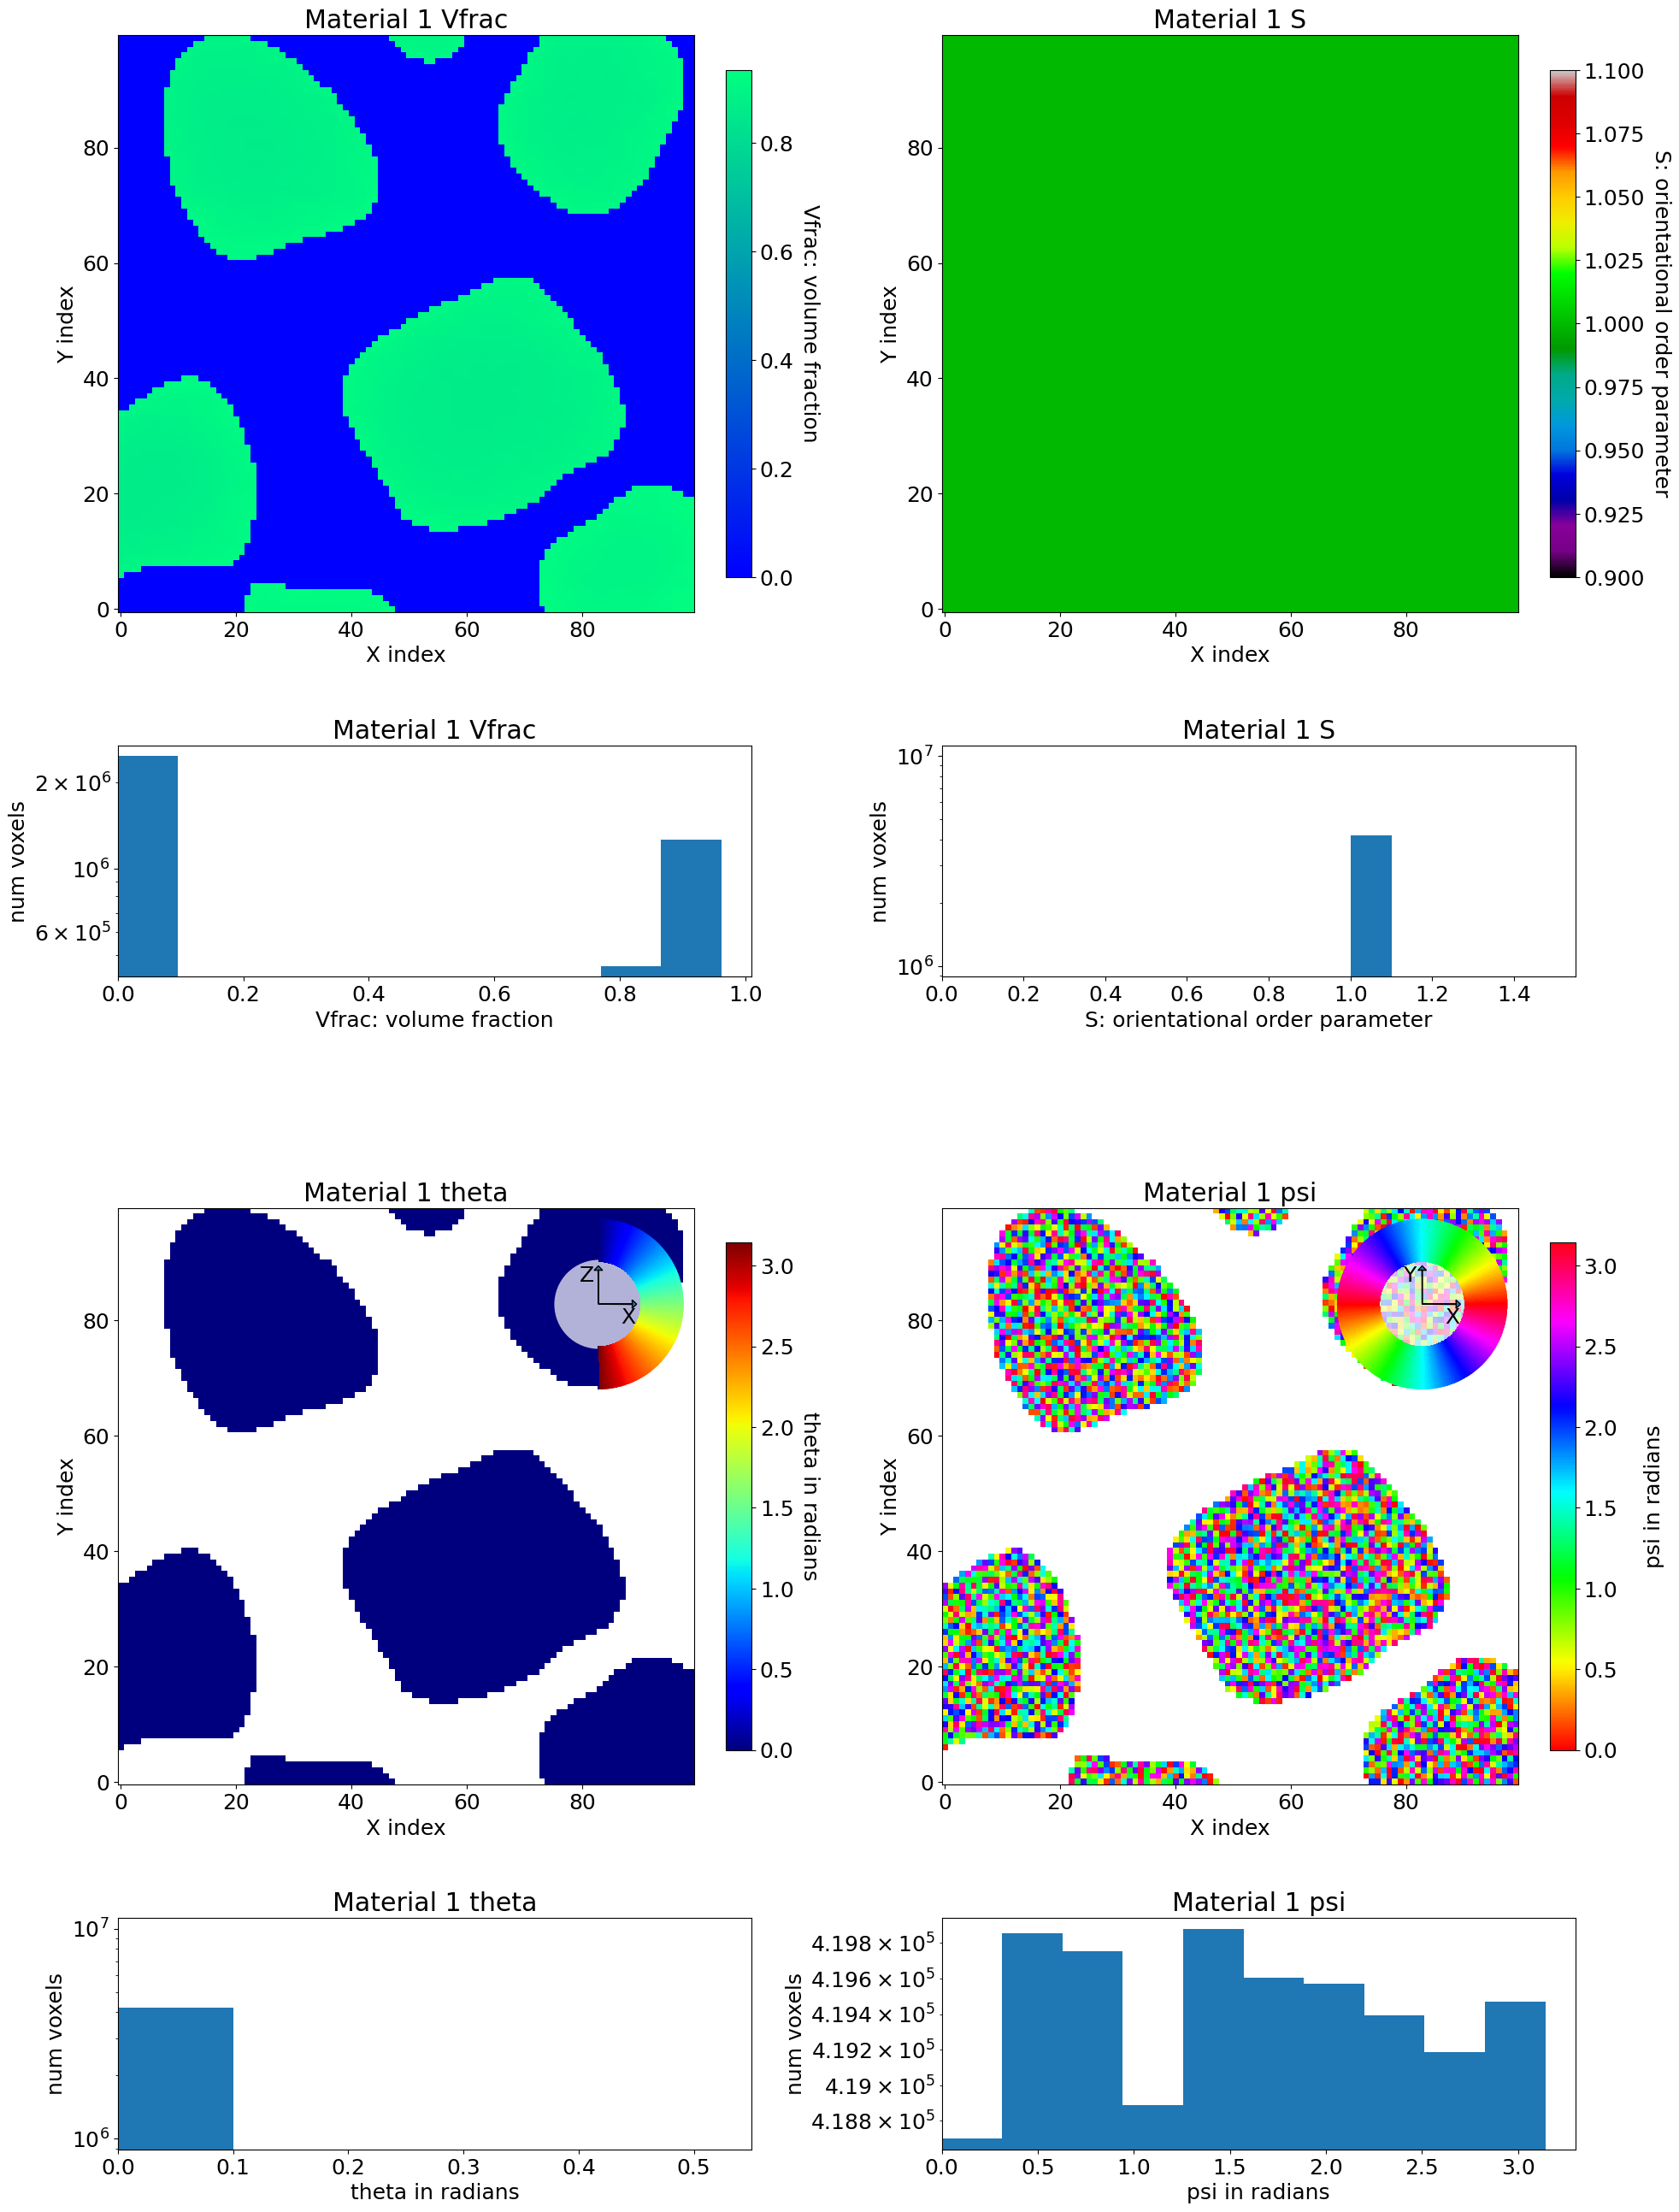

Material 2 Vfrac. Min: 0.0 Max: 1.0
Material 2 S. Min: 1.0 Max: 1.0
Material 2 theta. Min: 0.0 Max: 0.0
Material 2 psi. Min: 5.347391427537864e-07 Max: 3.141592617272476


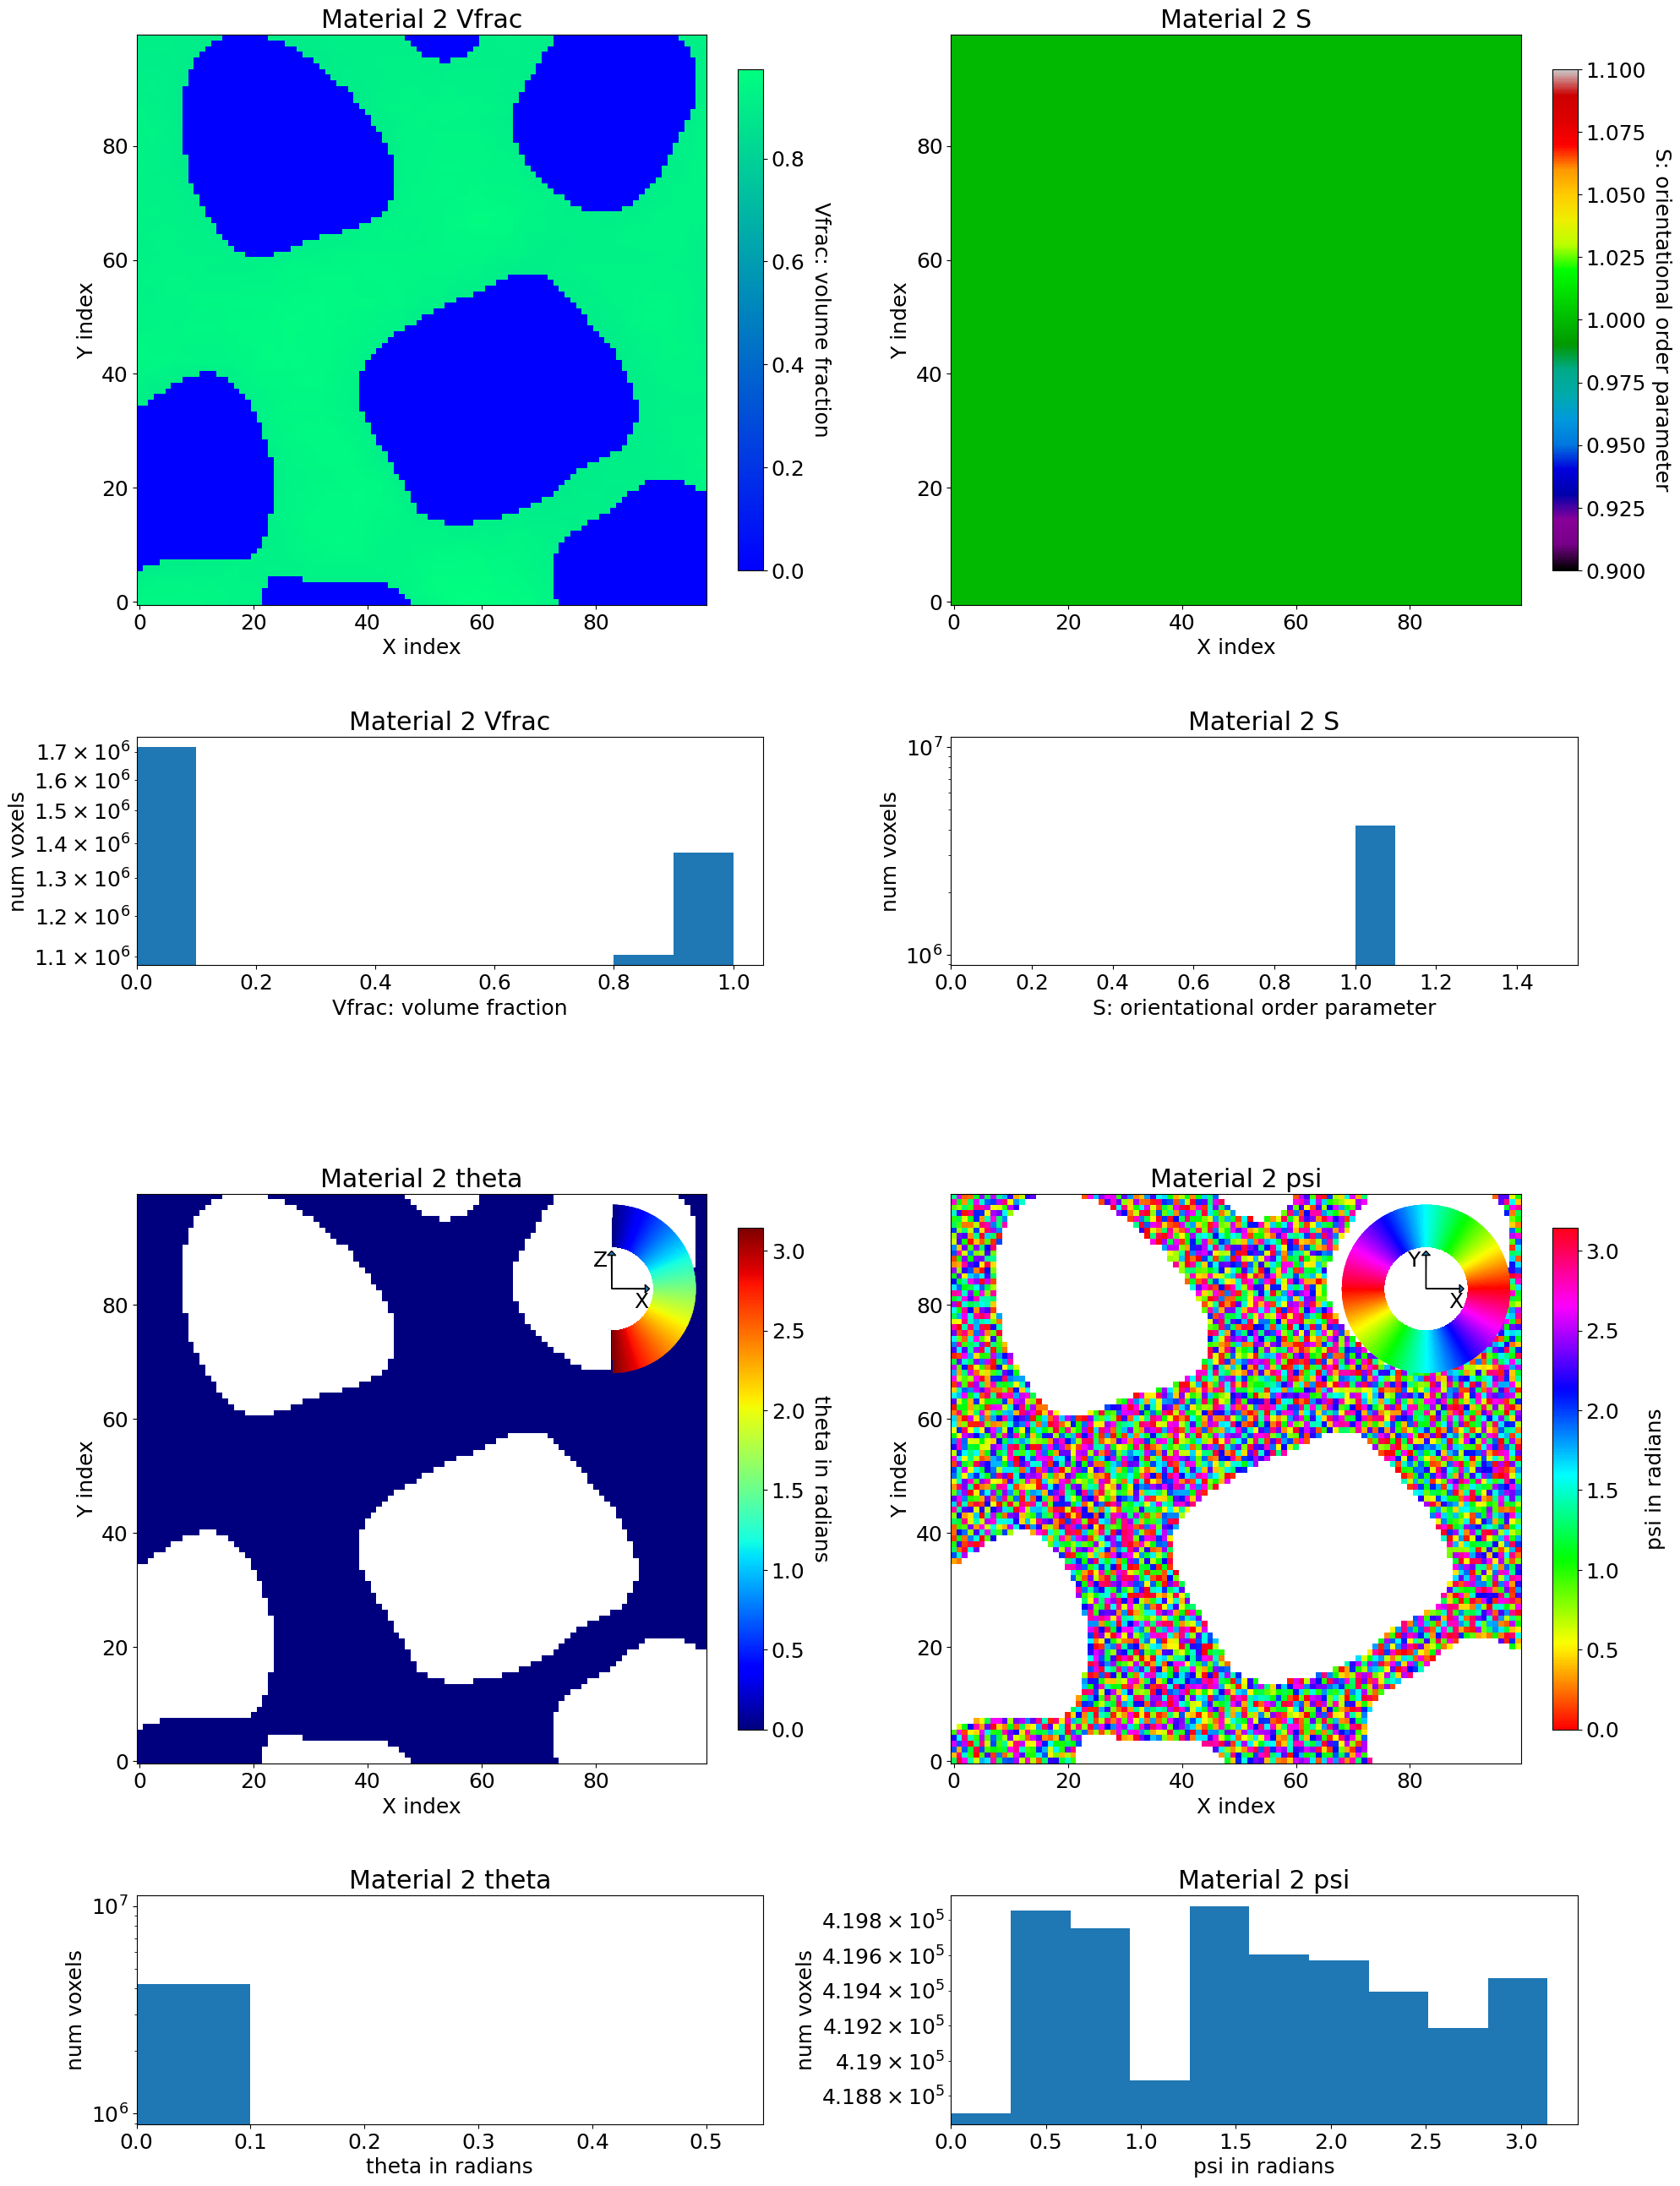

Material 3 Vfrac. Min: 0.0 Max: 0.14980599099798217
Material 3 S. Min: 0.0 Max: 0.0
Material 3 theta. Min: 0.0 Max: 0.0
Material 3 psi. Min: 0.0 Max: 0.0


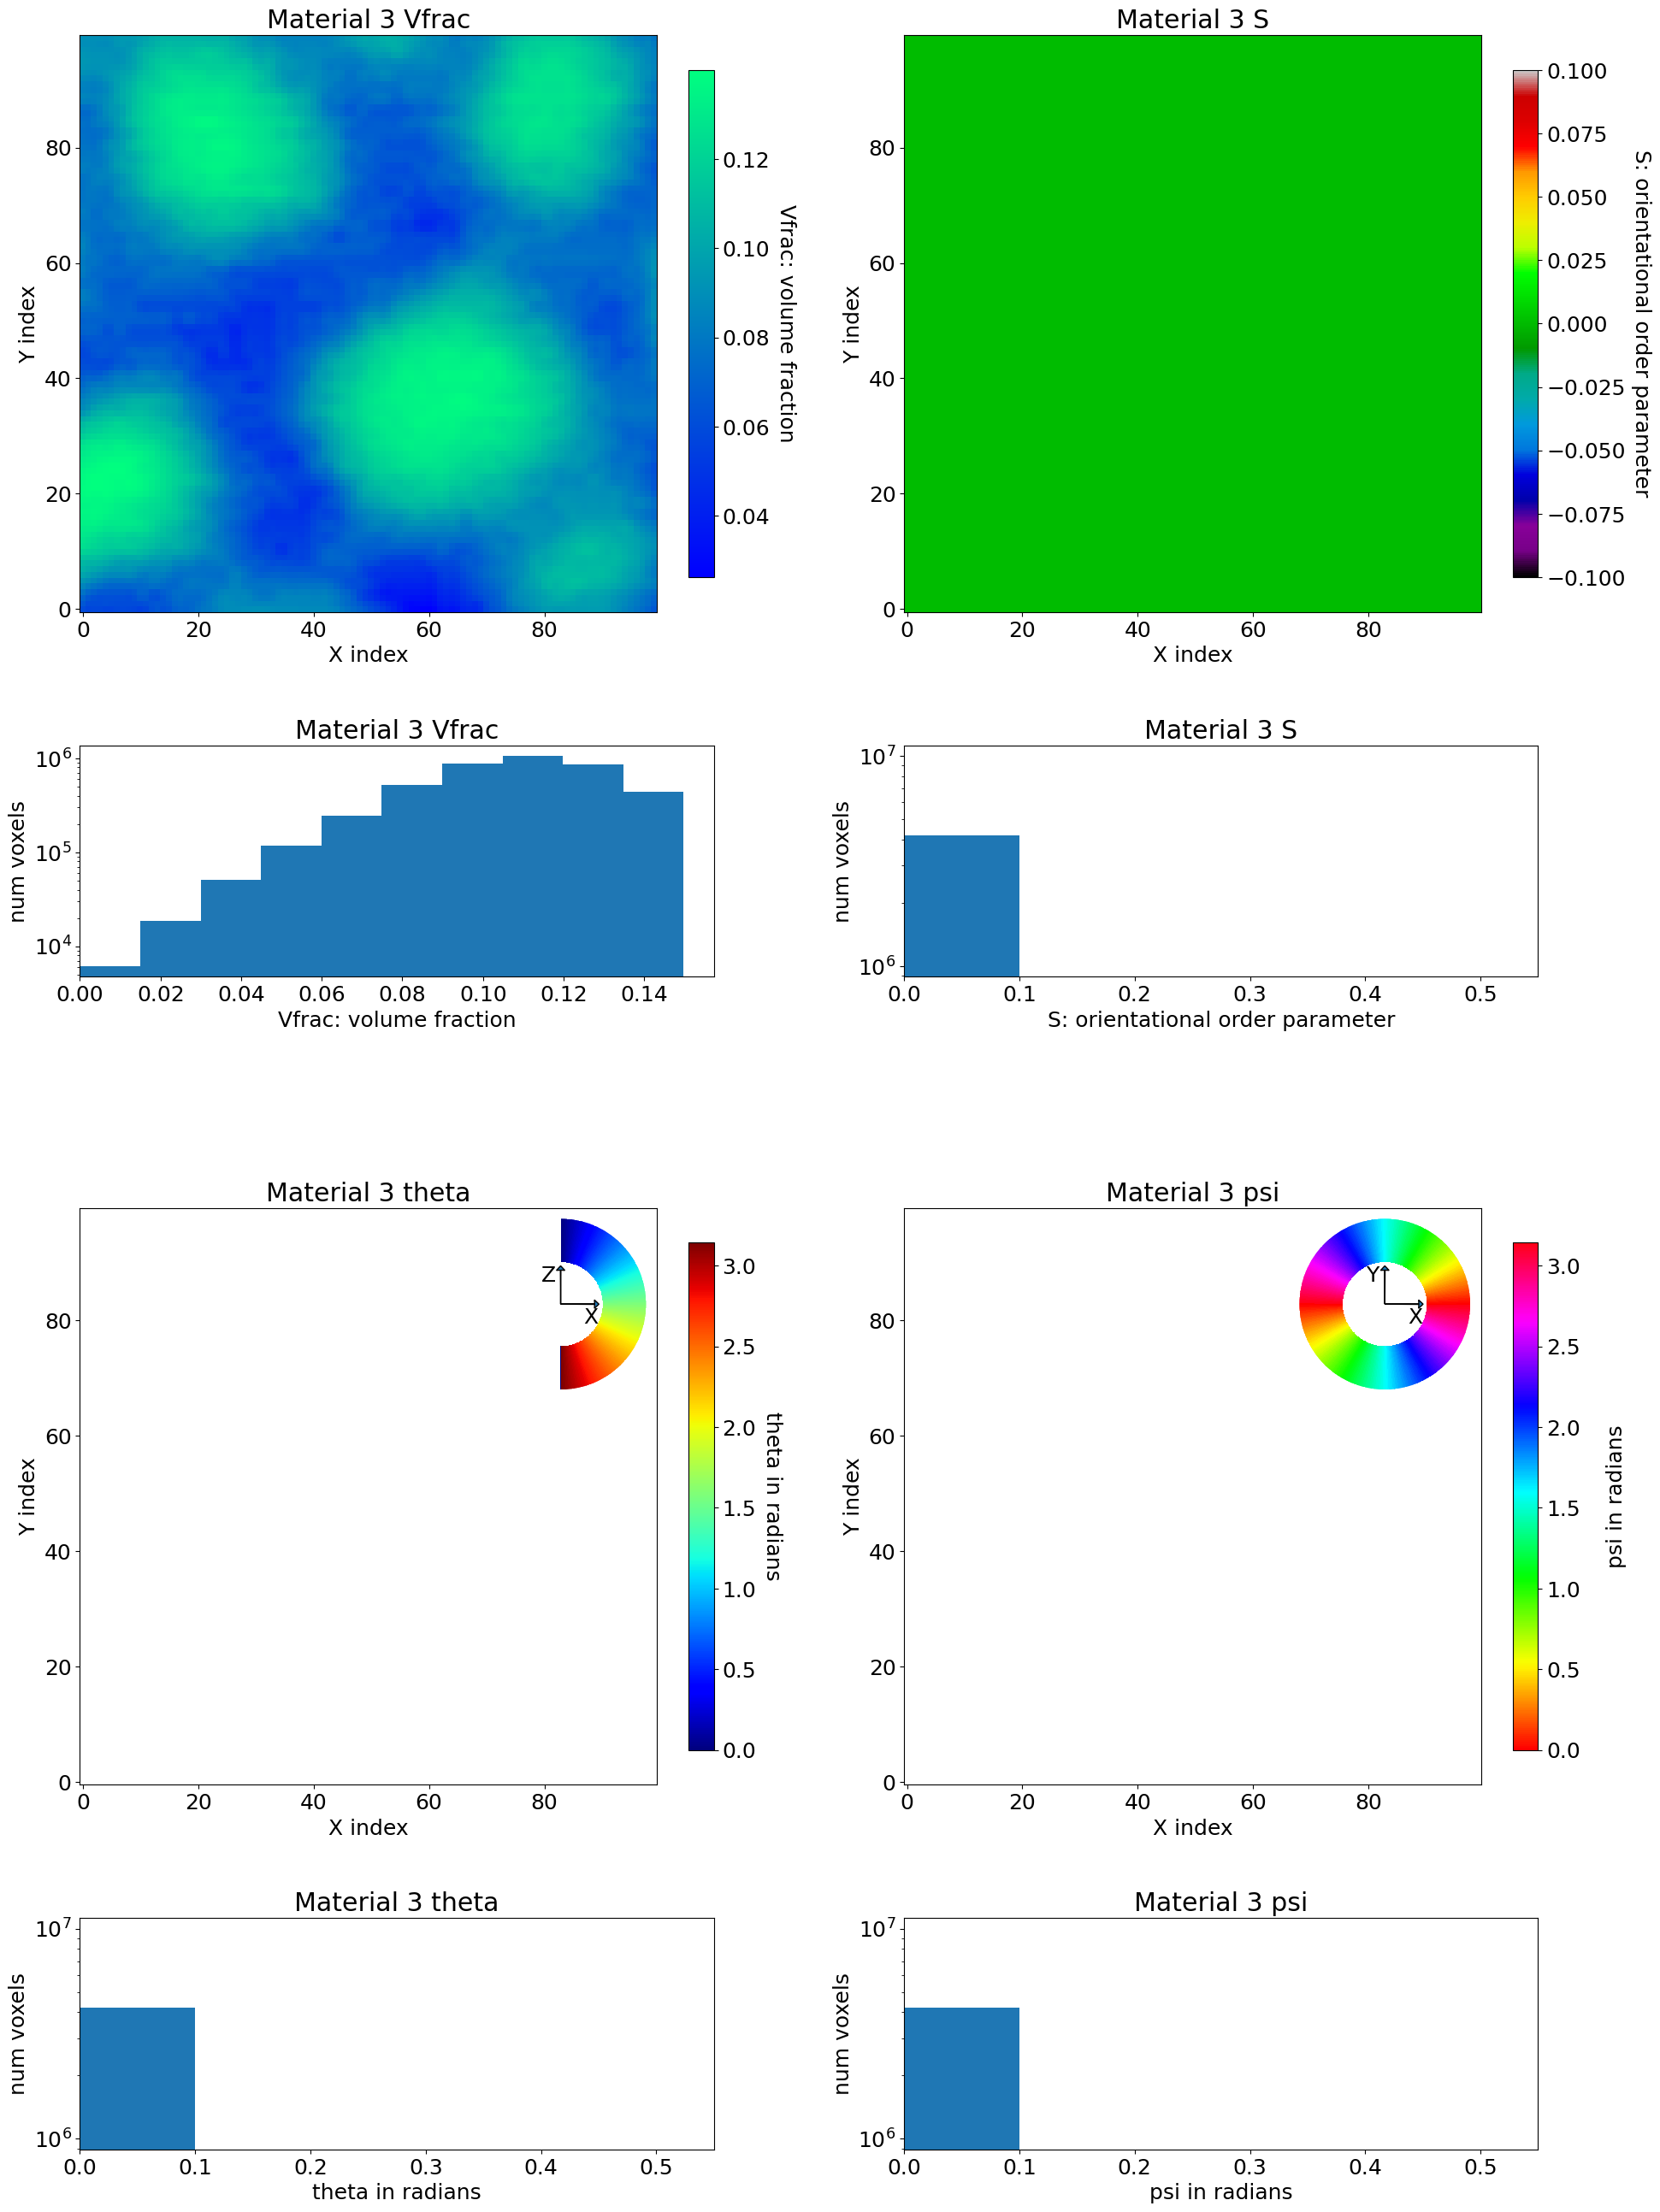

Total Vfrac whole model. Min: 1.0 Max: 1.0
0:00:06.930848


In [158]:
runner = '/home/ceb10/Jan2023/'

identifier = ''

morph, holeS1_binary, matrixS1_binary = base_morph_2D_purityblurS1tests(AFM_info_310,theta_set=0.)

MG_Nov.save_hdf5(f'{runner}S1_theta0_glassy.h5', morph, 1.95, 3, mformat='ZYX')
chk.checkH5(filename=f'{runner}S1_theta0_glassy.h5',subsample=100)

In [159]:
ht.runslurm_cb(runner,identifier,'cbscript.sh','S1_theta0_glassy.h5','tempS1_th0.nc')

Submitted batch job 537108


In [160]:
openedNC = xr.open_dataarray('tempS1_th0.nc'); q_sim = np.asarray(openedNC['q'])
I_sim = openedNC.sel(energy=energies[i],chi=slice(0,360)).mean(dim='chi'); I_sim = np.asarray(I_sim)

# pero, I think the most important thing to look at is anisotropy
I_para = openedNC.sel(energy=energies[i],chi=slice(0,45)).mean(dim='chi'); I_paraS0_theta0 = np.asarray(I_para)
I_perp = openedNC.sel(energy=energies[i],chi=slice(45,90)).mean(dim='chi'); I_perpS0_theta0 = np.asarray(I_perp)

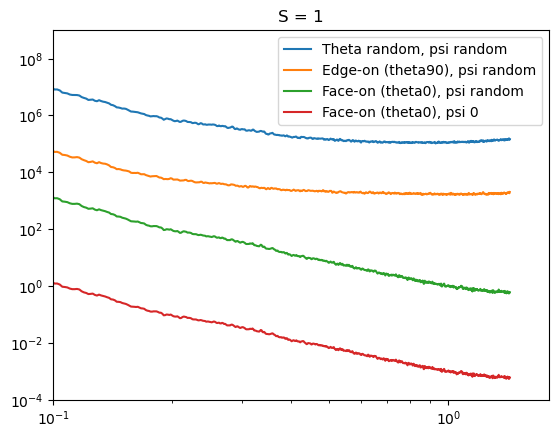

In [170]:
plt.close()
plt.subplots()
plt.plot(q_sim, I_paraS1*10000000, label='Theta random, psi random') # theta = random, psi = random
plt.plot(q_sim,I_paraS0_theta90*100000, label = 'Edge-on (theta90), psi random') # theta = 90, psi = random
plt.plot(q_sim,I_paraS0_theta0*1000, label = 'Face-on (theta0), psi random') # theta = 90, psi = random
plt.plot(q_sim, I_paraS1_wrong, label='Face-on (theta0), psi 0') # theta = 0, psi = 0
# ax2.plot(q_sim, I_perpS1_wrong, label='perp')
plt.legend()
plt.loglog()
plt.title('S = 1')
plt.xlim(0.1,1.8); plt.ylim(0.0001,10**9)
plt.show()

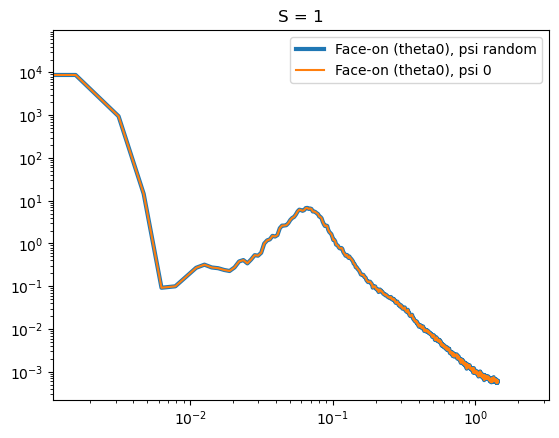

In [167]:
plt.close()
plt.subplots()
plt.plot(q_sim,I_paraS0_theta0, linewidth=3, label = 'Face-on (theta0), psi random') # theta = 90, psi = random
plt.plot(q_sim, I_paraS1_wrong, label='Face-on (theta0), psi 0') # theta = 0, psi = 0
# ax2.plot(q_sim, I_perpS1_wrong, label='perp')
plt.legend()
plt.loglog()
plt.title('S = 1')
plt.show()

### stopping end of 1/30/23

In [15]:
hTPD_nm = 4.; hDO_nm = 4.
hTPDvox = hTPD_nm / 1.95; hDOvox = hDO_nm / 1.95

S1_Vfrac_A = np.copy(S1_base_morph[0]); S1_thetanew_A = np.copy(S1_base_morph[2]); S1_psinew_A = np.copy(S1_base_morph[3])
S1_Vfrac_B = np.copy(S1_base_morph[4]); S1_thetanew_B = np.copy(S1_base_morph[6]); S1_psinew_B = np.copy(S1_base_morph[7])

S0_Vfrac_A = np.copy(S0_base_morph[0]); S0_thetanew_A = np.copy(S0_base_morph[2]); S0_psinew_A = np.copy(S0_base_morph[3])
S0_Vfrac_B = np.copy(S0_base_morph[4]); S0_thetanew_B = np.copy(S0_base_morph[6]); S0_psinew_B = np.copy(S0_base_morph[7])

In [16]:
from scipy.ndimage.morphology import distance_transform_edt
def scipy_edt(b): # this takes a boolean array, I believe
    """
    Uses euclidean distance, rather than old dilate/erode, to calculate distances from interfaces. Updated by team ~ Sep 2022
    
    Parameter b is a boolean array for a binarized morphology.
    """
    d_x = b.shape[0]
    d_y = b.shape[1] # x and y dimensions of the array
    dist = np.zeros([d_x,d_y]).astype(float) # setting up 0s to hold the distances
#    dist = 0.5-distance_transform_edt(b)
    dist[np.where(b==True)] = 0.5-distance_transform_edt(b)[np.where(b==True)]
    dist[np.where(b==False)] = distance_transform_edt(b==False)[np.where(b==False)] -0.5

    return dist

In [7]:
# the shell needs to be determined from a binary, and the isotropic morphology may have a blur to it with fractional numbers
a_med = hole_binary; b_med = matrix_binary 
dist_holes = scipy_edt(hole_binary)
dist_mat = scipy_edt(matrix_binary)
a_shell = (dist_holes < 0) * (dist_holes > -hTPDvox)
b_shell = (dist_mat < 0) * (dist_mat > -hDOvox) # the regions which will be oriented

In [8]:
a_mod = np.expand_dims(a_med,axis=0); b_mod = np.expand_dims(b_med,axis=0)
a_shell_mod = np.expand_dims(a_shell, axis=0); b_shell_mod = np.expand_dims(b_shell, axis=0)
a_gauss = gaussian(a_mod[0,:,:]*1.0,3,output=None,mode='nearest'); b_gauss = gaussian(b_mod[0,:,:]*1.0,3,output=None,mode='nearest')
a_grad = np.gradient(a_gauss); b_grad = np.gradient(b_gauss)
# choosing if there's a distribution of theta values in the shell (should be ~>60)

### Take care of the 4 different material regions:
Note: not going to pay attention to a theta distribution in the shell for right now
#### 1. TPD interface

### Define material distributions

In [9]:
import random; np.random.seed(10)
# bulk randomness; these will be chosen from for isotropic bulk things
bulk_psi_dist = np.random.uniform(0.,2*np.pi,np.shape(a_med)) # everything not at an interface will have random psi
DObulk_theta_dist = np.random.uniform(0.,2*np.pi,np.shape(a_med)) # all DO37 not at an interface will have random theta

Tsub = 310
# bulk GIWAXS-derived distributions
if Tsub == 280:
    distribution = np.loadtxt('/home/ceb10/ExperimentalData/TPDGIWAXS_Integrations_Ediger/260K_polyfit_probabilities.txt') # this wasn't working within the notebook, so may have to fine-tune
    TPDbulk_theta_dist = random.choices(distribution[:,0],weights=distribution[:,1],k=2048**2)
    TPDbulk_theta_dist= (np.pi/180)*np.reshape(TPDbulk_theta_dist,(2048,2048)) # if in the bulk of TPD at this Tsub, there will be a certain theta distribution
elif Tsub == 310:
    distribution = np.loadtxt('/home/ceb10/ExperimentalData/TPDGIWAXS_Integrations_Ediger/315K_polyfit_probabilities.txt')
    TPDbulk_theta_dist = random.choices(distribution[:,0],weights=distribution[:,1],k=2048**2)
    TPDbulk_theta_dist = (np.pi/180)*np.reshape(TPDbulk_theta_dist,(2048,2048)) # if in the bulk of TPD at this Tsub, there will be a certain theta distribution
elif Tsub == 325:
    TPDbulk_theta_dist = DObulk_theta # if at high Tsub, theta is just completely random


In [10]:
default_theta_shell_deg = 90.
edge_on = True
for i in range(0,np.shape(a_shell)[0]): # all x
    for j in range(0,np.shape(a_shell)[1]): # all y
        if a_shell[i,j] == True: # if something is part of the TPD shell, (DO37 or TPD)
            thetanew_A[0,i,j] = default_theta_shell_deg*np.pi/180.
            thetanew_B[0,i,j] = default_theta_shell_deg*np.pi/180. 
            if edge_on==False:
                psinew_A[0,i,j] = np.arctan2(a_grad[0][i,j],a_grad[1][i,j]) # keep the same radial orientation
                psinew_B[0,i,j] = np.arctan2(a_grad[0][i,j],a_grad[1][i,j]) 
            else:
                psinew_A[0,i,j] = np.arctan2(a_grad[0][i,j],a_grad[1][i,j]) + np.pi/2 # keep the same radial orientation
                psinew_B[0,i,j] = np.arctan2(a_grad[0][i,j],a_grad[1][i,j]) + np.pi/2# this is looking for DO blended into the TPD shell - It gets to have the same orientation as the DO37 shell, which I think is correct
        if b_shell[i,j] == True: # if something is part of the DO37 shell
            thetanew_A[0,i,j] = default_theta_shell_deg*np.pi/180. # We are just assuming that all of the non-shell molecules are oriented with pi systems completely parallel to substrate
            thetanew_B[0,i,j] = default_theta_shell_deg*np.pi/180.
            if edge_on==False:
                psinew_A[0,i,j] = np.arctan2(a_grad[0][i,j],a_grad[1][i,j]) # keep the same radial orientation
                psinew_B[0,i,j] = np.arctan2(a_grad[0][i,j],a_grad[1][i,j]) 
            else:
                psinew_A[0,i,j] = np.arctan2(a_grad[0][i,j],a_grad[1][i,j]) + np.pi/2 # keep the same radial orientation
                psinew_B[0,i,j] = np.arctan2(a_grad[0][i,j],a_grad[1][i,j]) + np.pi/2
        
        # need to modify this to also look at the DO37
        elif (a_med[i,j]==True) and (a_shell[i,j]==False): # if it's in the TPD composition, but is not included in either of the interfacial regions (maybe this is the key I was missing)
            thetanew_A[0,i,j] = TPDbulk_theta_dist[i,j]
            psinew_A[0,i,j] = bulk_psi_dist[i,j]
        elif (b_med[i,j]==True) and (b_shell[i,j]==False):
            thetanew_B[0,i,j] = DObulk_theta_dist[i,j]
            psinew_B[0,i,j] = bulk_psi_dist[i,j]
        else: # it's not in either of the shells or in the bulk TPD
            pass    

In [11]:
# bulk_psi = np.random.uniform(0.,2*np.pi,np.shape(a_med))
# bulk_theta = np.random.uniform(0.,2*np.pi,np.shape(a_med))
# plt.imshow(bulk_psi[0:50,0:50])
# plt.colorbar()
# plt.show()

In [12]:
# bulk_theta = np.random.uniform(0.,2*np.pi,np.shape(a_med))
# plt.imshow(bulk_theta[0:50,0:50])
# plt.colorbar()
# plt.show()

In [21]:
#modified_morph = np.copy(isotropic_morph)
real_mod_morph = [Vfrac_A, isotropic_morph[1], thetanew_A, psinew_A, Vfrac_B, isotropic_morph[1], thetanew_B, psinew_B, isotropic_morph[8], isotropic_morph[9], isotropic_morph[10], isotropic_morph[11] ]


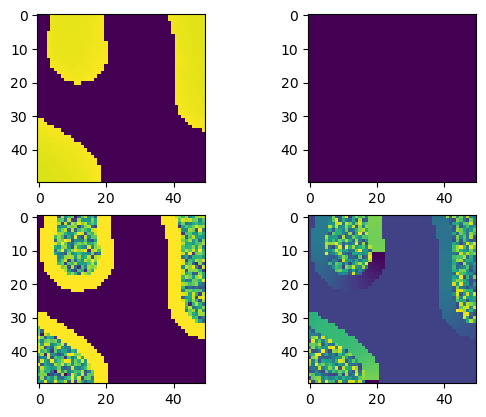

In [26]:
plt.close()
fig, ([ax1,ax2],[ax3,ax4]) = plt.subplots(2,2)
ax1.imshow(real_mod_morph[0][0][0:50,0:50])
ax2.imshow(real_mod_morph[1][0][0:50,0:50])
ax3.imshow(real_mod_morph[2][0][0:50,0:50])
ax4.imshow(real_mod_morph[3][0][0:50,0:50])
plt.show()

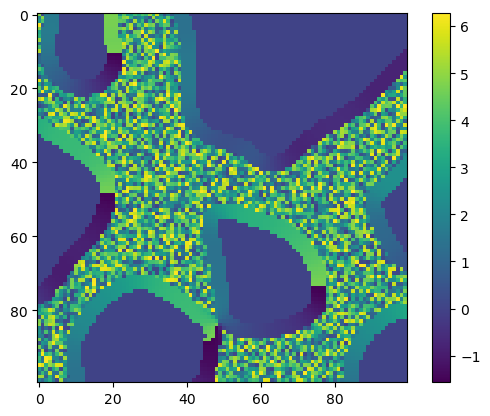

In [36]:
plt.close()
plt.imshow(real_mod_morph[7][0][0:100,0:100])
plt.colorbar()
plt.show()

In [ ]:
# def run_one_theta(running_directory,AFM_info,purity,sigma_blur_nm,noisefloor,Tsub,hTPD_nm,
#                   hDO_nm,STPD,SDO,theta_dist=True,minmax_theta=(60.,90.),theta_deg=90.,Eshift=0.5,face_on=False,outputTXTfolder='dummy'):
    
#     AFM_file = AFM_info[0]; Tsub = AFM_info[1]; h_film = AFM_info[2]; hminus = AFM_info[3]; hplus = AFM_info[4];
#     block_size = AFM_info[5]; filter_size = AFM_info[6]; offset = AFM_info[7]; voxel_size = AFM_info[8]; res = AFM_info[9]

#     morph = MG.euc_morphology_20221109(AFM_info, purity, sigma_blur_nm,hTPD_nm, hDO_nm, STPD, SDO, add_OOP=False,theta_dist_shell=False,default_theta_shell_deg=theta_deg)
#     os.chdir(running_directory)
#     #identifier = f'{Tsub}K_{round(hTPD_nm,2)}nmTPD_{round(hDO_nm,2)}nmDO_{round(purity,2)}%pure_{round(sigma_blur_nm,2)}nmBlur{theta_deg}theta'
#     identifier = f'{Tsub}K_theta{theta_deg}_deg'
    
#     ht.reset_dir(f'{running_directory}/{identifier}/')
    
#     MG.save_hdf5(f'{running_directory}/{identifier}/{identifier}_glassy.h5', morph, 1.95, 3, mformat='ZYX')
        
#     os.symlink(f'{running_directory}/config.txt',f'{running_directory}/{identifier}/config.txt')
#     os.symlink(f'{running_directory}/Material1.txt',f'{running_directory}/{identifier}/Material1.txt')
#     os.symlink(f'{running_directory}/Material2.txt',f'{running_directory}/{identifier}/Material2.txt')
#     os.symlink(f'{running_directory}/Material3.txt',f'{running_directory}/{identifier}/Material3.txt')
    
    
#     os.chdir(running_directory)
#     #ht.runslurm_cb(running_directory,identifier,'cbscript.sh',f'{identifier}_glassy.h5','temp.nc')
#     ht.runslurm_cb(running_directory,identifier,'cbscript.sh',f'{identifier}_glassy.h5','temp.nc')
    
# #     mse = quick_Ifit_test(NCfile=f'{running_directory}/{identifier}/temp.nc',expt_file=experimental,energy=270.0,Tsub=Tsub,noisefloor=noisefloor,outputPNGfolder=outputPNGfolder,
# #                          purity=purity, sigma_nm=sigma_blur_nm,ID=identifier)
#     #print(f'{running_directory}/{identifier}/temp.nc')
#     os.chdir(f'{running_directory}{identifier}/')
#     E,A = AvsE_textout(NCfile=f'{running_directory}{identifier}/temp.nc',Tsub=Tsub,identifier=identifier,save_directory=outputTXTfolder)
        
#     try:
#         shutil.rmtree(f'{running_directory}/{identifier}')
#     except OSError:
#         pass
#     # deleted the directory
#     return